# Задача "Прогноз состава сырья"

## Описание задачи
На нефтехимические заводы СИБУР сырье (широкая фракция легких углеводородов - ШФЛУ) поступает по трубопроводу. Трубопровод наполняется на нескольких станциях подкачки, которые расположены последовательно на пути к потребителю.

Состав ШФЛУ меняется на каждой станции с течением времени и, таким образом, меняется итоговый состав ШФЛУ, которую получает потребитель. Имея достоверный прогноз по составу можно оптимизировать некоторые технологические процессы.

Вам предстоит построить прогноз состава поступающей по трубопроводу ШФЛУ на основании данных с последней перед потребителем станции подкачки. При этом геометрия трубопровода, расстояние от станции подкачки до потребителя и другие параметры трубопровода не раскрываются.

Метрикой в этой задаче служит средняя по всем целевым переменным MAPE.

## Данные
Данные содержат расходы сырья в т/ч для станции подкачки A (A_rate) и потребителя B (B_rate), а также массовые процентные доли различных компонент на станции A (A_CH4, A_C2H6, A_C3H8, A_iC4H10, A_nC4H10, A_iC5H12, A_nC5H12, A_C6H14).

Целевые переменные: массовые процентные доли нескольких компонент на станции B (B_C2H6, B_C3H8, B_iC4H10, B_nC4H10). Целевые переменные для тестового периода не содержат разрывов, поэтому загружаемое решение должно содержать все временные метки из тестового множества.

train_targets.csv - целевые переменные для тренировочного множества
train_features.csv - признаки для тренировочного множества
test_features.csv - признаки для тестового множества
sample_submission.csv - пример решения в правильном формате

## Вебинар
На вебинаре организаторы разъяснили немного условия задачи.
Есть трубопровод по которому подается ШФЛУ из сечения А в сечение В. По пути из А в В присутствует подкачка ШФЛУ более-менее стабильного состава. Расход данной подкачки можно определить на основании данных в условии задачи расходов в А и В.

G - массовый расход ШФЛУ, х - процентный массовый состав ШФЛУ по каждому компоненту

<center>
<img src="Schem.jpg">

Первое что приходит в голову - задача на **структуру потоков**.

Если бы были данные по устройству трубопровода (геометрия, топология, арматура), температура и давление ШФЛУ, результаты гидродинамических испытаний по структуре потока (кривые распределения времени пребывания, плотности распределения, кривые отклика) можно было бы попытаться создать модель (ячеечную или диффузионную), а также попробовать её решить численно, либо создать гибридную модель. Но данных таких нет и не всегда они бывают даже у датасайнтистов из Сибура...
    
    
Кстати, в интернете нашел интересную статью как раз по моделированию смешения и коэффициента продольного перемешивания (эффективная диффузия) - "*Новый метод расчета многопродуктовых магистральных
трубопроводов*", А.С. Дидковская

## Посмотрим на данные

In [594]:
import numpy as np
import pandas as pd
import seaborn as sns
import math as m

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
%matplotlib inline

In [595]:
import warnings
warnings.filterwarnings('ignore')

In [596]:
train_features = pd.read_csv('train_features.csv', header = 0, sep = ',')
test_features = pd.read_csv('test_features.csv', header = 0, sep = ',')
train_target = pd.read_csv('train_targets.csv', header = 0, sep = ',')

In [597]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [598]:
train_features[:]

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 00:00:00  70.855017       NaN       NaN        NaN   
1     2020-01-01 00:30:00  70.826582       NaN       NaN        NaN   
2     2020-01-01 01:00:00  70.809637       NaN       NaN        NaN   
3     2020-01-01 01:30:00  69.994748       NaN       NaN        NaN   
4     2020-01-01 02:00:00  70.072762       NaN       NaN        NaN   
...                   ...        ...       ...       ...        ...   
5803  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5804  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5805  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5806  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5807  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0           NaN        NaN       NaN       NaN       NaN  71.982789  
1           NaN        NaN       NaN       NaN       NaN  71.965098  
2           NaN        NaN       NaN       NaN       NaN  71.867409  
3           NaN        NaN       NaN       NaN       NaN  71.839126  
4           NaN        NaN       NaN       NaN       NaN  71.336921  
...         ...        ...       ...       ...       ...        ...  
5803  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  
5804  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  
5805  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  
5806  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  
5807  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  

[5808 rows x 11 columns]

In [599]:
train_features.corr()

A_rate     A_CH4    A_C2H6    A_C3H8  A_iC4H10  A_nC4H10  \
A_rate    1.000000  0.140528  0.437019  0.418836  0.017336 -0.430159   
A_CH4     0.140528  1.000000  0.335366  0.200776 -0.154180 -0.337805   
A_C2H6    0.437019  0.335366  1.000000  0.527549 -0.100987 -0.701938   
A_C3H8    0.418836  0.200776  0.527549  1.000000  0.486148 -0.709767   
A_iC4H10  0.017336 -0.154180 -0.100987  0.486148  1.000000  0.199295   
A_nC4H10 -0.430159 -0.337805 -0.701938 -0.709767  0.199295  1.000000   
A_iC5H12 -0.399400 -0.150923 -0.514814 -0.940113 -0.645688  0.546690   
A_nC5H12 -0.367528 -0.155106 -0.540416 -0.930008 -0.659884  0.523956   
A_C6H14  -0.318311 -0.128191 -0.407348 -0.881589 -0.686246  0.384840   
B_rate    0.962491  0.051154  0.341268  0.231222 -0.167036 -0.273329   

          A_iC5H12  A_nC5H12   A_C6H14    B_rate  
A_rate   -0.399400 -0.367528 -0.318311  0.962491  
A_CH4    -0.150923 -0.155106 -0.128191  0.051154  
A_C2H6   -0.514814 -0.540416 -0.407348  0.341268  
A_C3H8   -0.940113 -0.930008 -0.881589  0.231222  
A_iC4H10 -0.645688 -0.659884 -0.686246 -0.167036  
A_nC4H10  0.546690  0.523956  0.384840 -0.273329  
A_iC5H12  1.000000  0.975426  0.862518 -0.224065  
A_nC5H12  0.975426  1.000000  0.877563 -0.178315  
A_C6H14   0.862518  0.877563  1.000000 -0.122962  
B_rate   -0.224065 -0.178315 -0.122962  1.000000

In [600]:
train_features.describe()

A_rate        A_CH4       A_C2H6       A_C3H8     A_iC4H10  \
count  5807.000000  4849.000000  4849.000000  4849.000000  4849.000000   
mean     59.346948     0.159890     4.290739    37.990406    17.343168   
std      20.684895     0.068488     0.912565     3.756424     0.754301   
min       0.000321     0.008045     0.280524    11.345740    11.143152   
25%      61.846908     0.109331     3.971011    37.647968    17.018272   
50%      67.010148     0.139924     4.485758    38.618187    17.327200   
75%      69.734038     0.212163     4.844390    39.402360    17.685803   
max      74.560399     0.471429     6.418897    42.860283    20.353500   

          A_nC4H10     A_iC5H12     A_nC5H12      A_C6H14       B_rate  
count  4849.000000  4849.000000  4849.000000  4849.000000  5675.000000  
mean     24.413897     4.948636     4.809805     5.995740    64.817202  
std       1.274795     1.230539     1.285549     1.543956    10.696414  
min      18.655932     3.033678     1.338103     2.924722     0.000000  
25%      23.746663     4.462670     4.353103     5.574106    63.852030  
50%      24.138643     4.684908     4.619459     5.708216    68.583359  
75%      24.615843     5.086816     4.925770     6.032535    71.171153  
max      35.498867    13.812560    14.845480    30.656385    89.958390

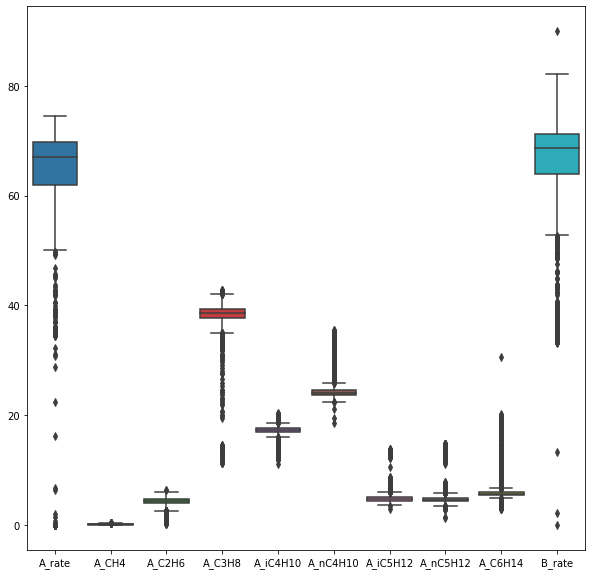

In [601]:
plt.rcParams["figure.figsize"] = (10,10)
sns.boxplot(data=train_features)

In [602]:
train_features.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
dtype: int64

In [603]:
train_features.info()
train_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5808 non-null   object 
 1   A_rate     5807 non-null   float64
 2   A_CH4      4849 non-null   float64
 3   A_C2H6     4849 non-null   float64
 4   A_C3H8     4849 non-null   float64
 5   A_iC4H10   4849 non-null   float64
 6   A_nC4H10   4849 non-null   float64
 7   A_iC5H12   4849 non-null   float64
 8   A_nC5H12   4849 non-null   float64
 9   A_C6H14    4849 non-null   float64
 10  B_rate     5675 non-null   float64
dtypes: float64(10), object(1)
memory usage: 499.2+ KB


(5808, 11)

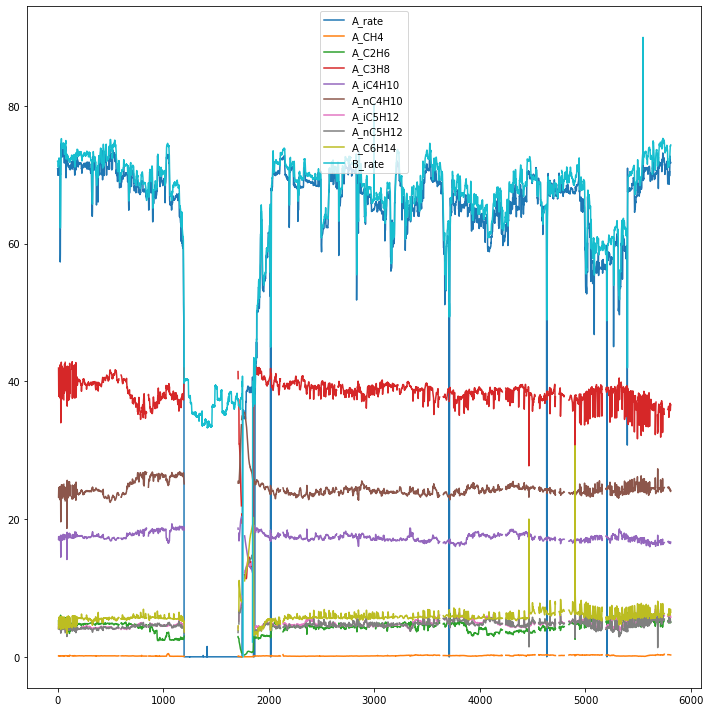

In [604]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [605]:
train_features[train_features["A_rate"] <= 40]

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
1197  2020-01-25 22:30:00  37.634787  0.068959  2.783333  39.613317   
1198  2020-01-25 23:00:00   0.001294  0.070249  2.903388  41.168760   
1199  2020-01-25 23:30:00   0.001701  0.071737  2.994731  41.935570   
1200  2020-01-26 00:00:00   0.001525       NaN       NaN        NaN   
1201  2020-01-26 00:30:00   0.001055       NaN       NaN        NaN   
...                   ...        ...       ...       ...        ...   
5201  2020-04-18 08:30:00  39.827838  0.240746  5.309529  38.752616   
5202  2020-04-18 09:00:00   0.002014  0.247586  5.250514  38.680070   
5203  2020-04-18 09:30:00   0.001633  0.261290  4.818443  38.907820   
5204  2020-04-18 10:00:00  38.215334  0.276025  4.567278  38.848842   
5396  2020-04-22 10:00:00  30.749718  0.110907  5.681407  38.414870   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
1197  18.374810  25.521723  4.473425  3.987337  5.163005  45.833590  
1198  18.650220  25.298560  4.232059  3.601516  4.062176  42.446206  
1199  18.765710  25.119170  4.089573  3.390231  3.620386  39.727496  
1200        NaN        NaN       NaN       NaN       NaN  39.972873  
1201        NaN        NaN       NaN       NaN       NaN  40.089745  
...         ...        ...       ...       ...       ...        ...  
5201  17.415626  24.286268  4.272327  4.035304  5.629434  56.099281  
5202  17.369883  24.286207  4.326687  4.089799  5.691831  48.813637  
5203  17.416410  24.441860  4.462670  4.187992  5.451690  49.964670  
5204  17.454773  24.491840  4.555090  4.260572  5.496899  48.964665  
5396  17.581315  24.102620  4.432917  3.888675  5.740080  54.846246  

[694 rows x 11 columns]

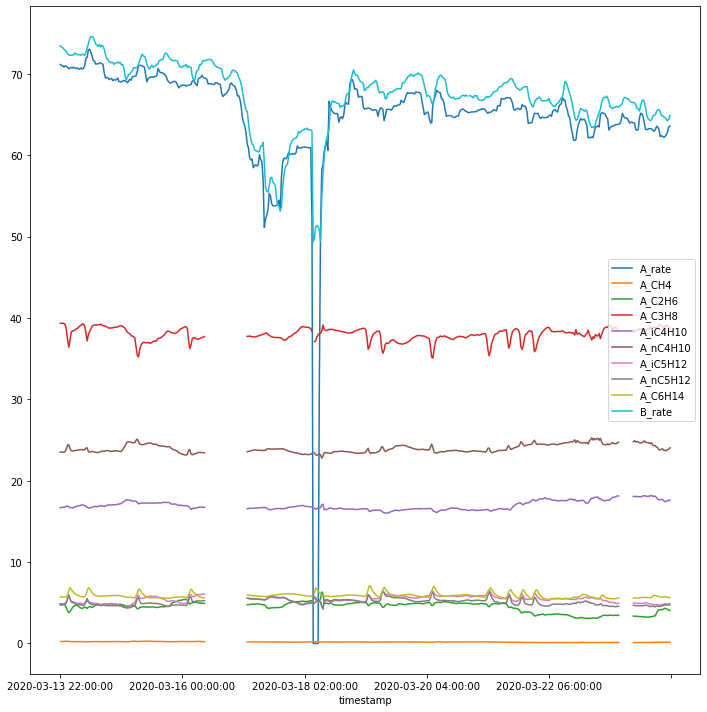

In [606]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[3500:4000].plot('timestamp')

# make room for tick labels
plt.tight_layout()


plt.show()

In [607]:
test_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-05-01 00:00:00  71.428342  0.267832  5.135159  36.816480   
1     2020-05-01 00:30:00  70.925118  0.268464  5.149646  36.869023   
2     2020-05-01 01:00:00  70.991719  0.270641  5.154615  37.074965   
3     2020-05-01 01:30:00  70.972406  0.275241  5.230661  37.384180   
4     2020-05-01 02:00:00  70.980078  0.275062  5.241437  37.448587   
...                   ...        ...       ...       ...        ...   
3979  2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930   
3980  2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418   
3981  2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323   
3982  2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503   
3983  2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0     16.632260  24.062587  5.696004  4.939430  6.395286  74.273009  
1     16.651870  24.069800  5.676384  4.911872  6.346957  74.061833  
2     16.710967  24.106152  5.574873  4.808516  6.242636  73.856268  
3     16.683337  24.021993  5.514843  4.730887  6.101647  73.750744  
4     16.663863  24.003237  5.524898  4.728882  6.057119  73.698447  
...         ...        ...       ...       ...       ...        ...  
3979  17.741460  24.098520  4.469224  3.619095  4.686205  75.486026  
3980  17.449352  24.049532  4.770699  3.988215  6.689777  75.370451  
3981  17.635380  24.169473  4.613603  3.790651  5.785216  74.985878  
3982  17.758833  24.211013  4.504242  3.657459  5.094626  74.766867  
3983  17.772225  24.088445  4.387957  3.536302  4.863965  74.804667  

[3984 rows x 11 columns]

In [608]:
test_features.isnull().sum()

timestamp       0
A_rate       1142
A_CH4         456
A_C2H6        451
A_C3H8        452
A_iC4H10      452
A_nC4H10      452
A_iC5H12      456
A_nC5H12      456
A_C6H14       455
B_rate          5
dtype: int64

In [609]:
test_features.info()
test_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3984 non-null   object 
 1   A_rate     2842 non-null   float64
 2   A_CH4      3528 non-null   float64
 3   A_C2H6     3533 non-null   float64
 4   A_C3H8     3532 non-null   float64
 5   A_iC4H10   3532 non-null   float64
 6   A_nC4H10   3532 non-null   float64
 7   A_iC5H12   3528 non-null   float64
 8   A_nC5H12   3528 non-null   float64
 9   A_C6H14    3529 non-null   float64
 10  B_rate     3979 non-null   float64
dtypes: float64(10), object(1)
memory usage: 342.5+ KB


(3984, 11)

In [610]:
test_features.describe()

A_rate        A_CH4       A_C2H6       A_C3H8     A_iC4H10  \
count  2842.000000  3528.000000  3533.000000  3532.000000  3532.000000   
mean     69.884320     0.162207     4.467679    39.109041    17.397629   
std       2.975072     0.051789     0.475805     2.194943     1.178583   
min       0.001292     0.000000     0.000000     3.891164     0.000000   
25%      69.168728     0.126446     4.236493    38.392097    16.856905   
50%      70.152686     0.147803     4.464768    39.061776    17.276783   
75%      71.289177     0.173982     4.731939    40.305470    18.068539   
max      74.346769     0.390817     6.551086   100.000000    54.028570   

          A_nC4H10     A_iC5H12     A_nC5H12      A_C6H14       B_rate  
count  3532.000000  3528.000000  3528.000000  3529.000000  3979.000000  
mean     23.899568     4.871338     4.450333     5.613259    72.461288  
std       0.851144     0.629635     0.666401     2.049381     2.221912  
min       0.000000     0.000000     0.000000     0.000000    44.154610  
25%      23.579122     4.381023     3.842573     4.748398    71.653297  
50%      23.898327     4.775210     4.565247     5.943392    72.612522  
75%      24.259839     5.196619     4.922047     6.127190    73.800168  
max      34.284363    13.819660    11.846500    83.718820    94.243585

По максимальным значениям можно обнаружить наличие выбросов

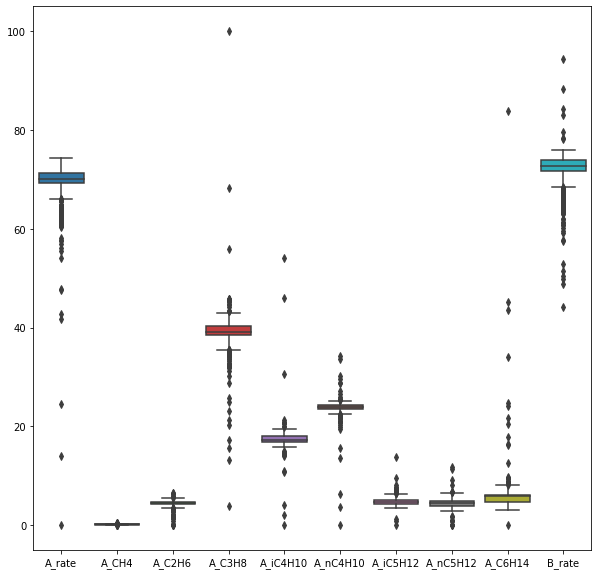

In [611]:
sns.boxplot(data=test_features)

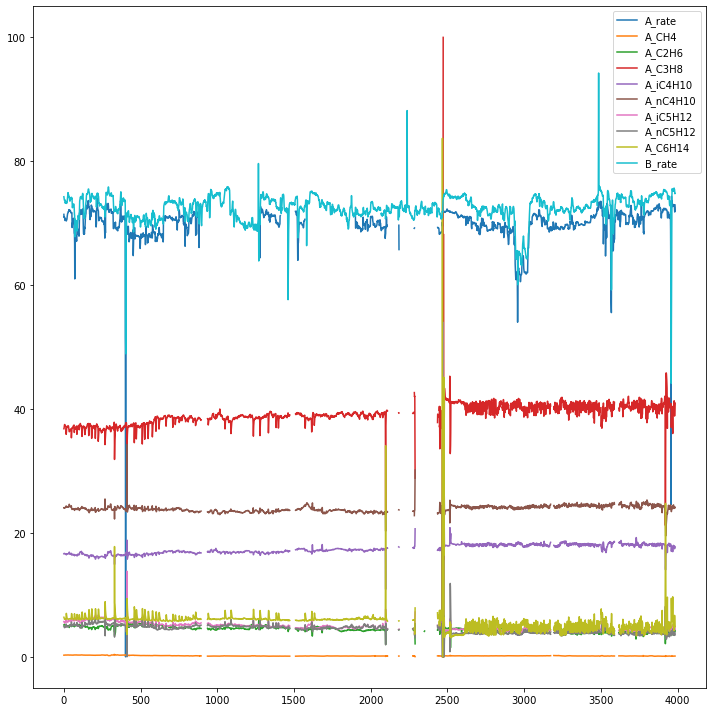

In [612]:
plt.rcParams["figure.figsize"] = (10,10)

test_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [613]:
#dict_clean = {'A_C3H8':45, 'A_iC4H10':30, 'A_C6H14':15}

In [614]:
#for i in range(1,test_features.shape[0]):
#    for j in dict_clean:
#        if test_features.loc[i,j] > dict_clean[j]:
#            test_features.loc[[i],[j]] = test_features.loc[[i-1],[j]]

In [615]:
train_target[:]

timestamp    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
0     2020-01-01 00:00:00  4.561979  39.015486  17.250740  24.301793
1     2020-01-01 00:30:00  4.550741  39.048915  17.229506  24.257461
2     2020-01-01 01:00:00  4.506793  38.766378  17.171621  24.236298
3     2020-01-01 01:30:00  4.584963  39.069360  17.218521  24.149843
4     2020-01-01 02:00:00  4.607483  38.817579  17.108668  24.049510
...                   ...       ...        ...        ...        ...
5803  2020-04-30 21:30:00  4.816865  35.539156  16.269938  24.770377
5804  2020-04-30 22:00:00  4.993286  36.067750  16.317757  24.729847
5805  2020-04-30 22:30:00  5.101574  36.275040  16.295460  24.629889
5806  2020-04-30 23:00:00  5.210675  36.872917  16.336359  24.438236
5807  2020-04-30 23:30:00  5.136487  35.860326  16.101509  24.426845

[5808 rows x 5 columns]

In [616]:
train_features.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
dtype: int64

In [617]:
train_target.info()
train_target.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5808 non-null   object 
 1   B_C2H6     5624 non-null   float64
 2   B_C3H8     5628 non-null   float64
 3   B_iC4H10   5628 non-null   float64
 4   B_nC4H10   5628 non-null   float64
dtypes: float64(4), object(1)
memory usage: 227.0+ KB


(5808, 5)

In [618]:
train_target.describe()

B_C2H6       B_C3H8     B_iC4H10     B_nC4H10
count  5624.000000  5628.000000  5628.000000  5628.000000
mean      4.363701    37.742757    16.843028    24.171264
std       2.931240     2.218569     1.059827     1.480740
min       0.861025     0.026142     0.012764     0.019941
25%       3.503610    36.827096    16.548084    23.736470
50%       4.395271    37.750088    16.934576    24.147675
75%       4.680156    38.730979    17.292647    24.642044
max      91.573613    61.931856    19.235807    27.184879

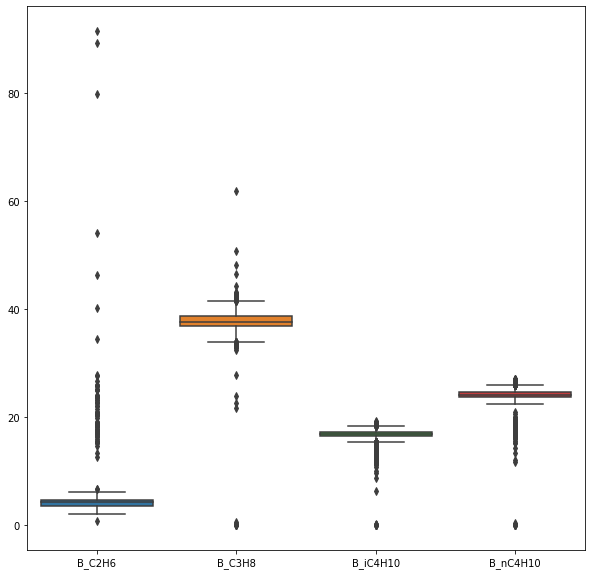

In [619]:
sns.boxplot(data=train_target)

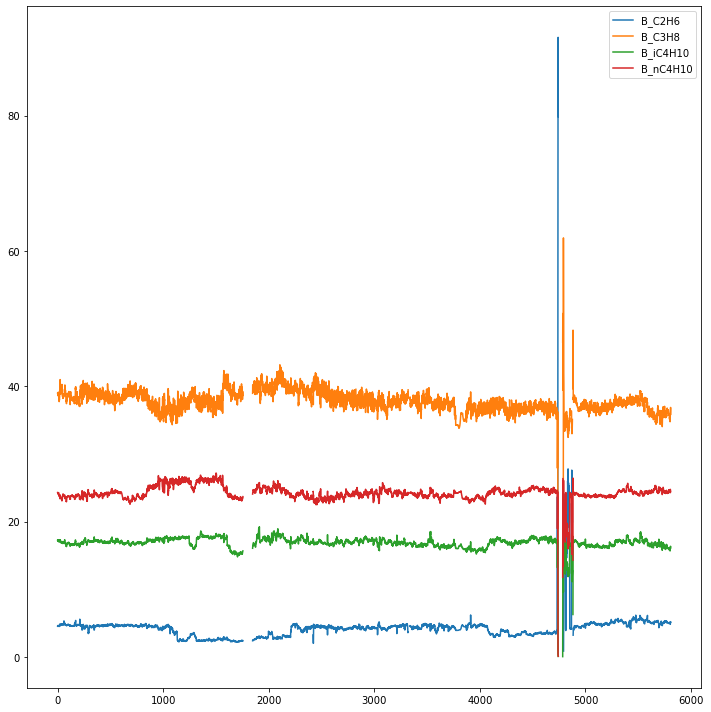

In [620]:
plt.rcParams["figure.figsize"] = (10,10)

train_target[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

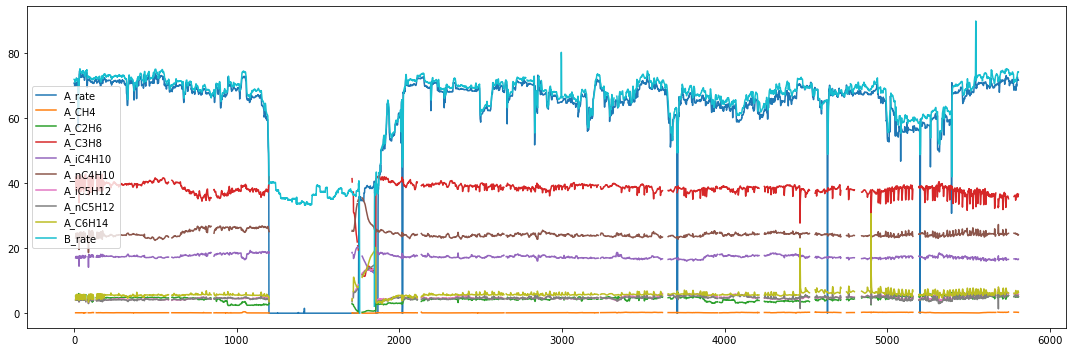

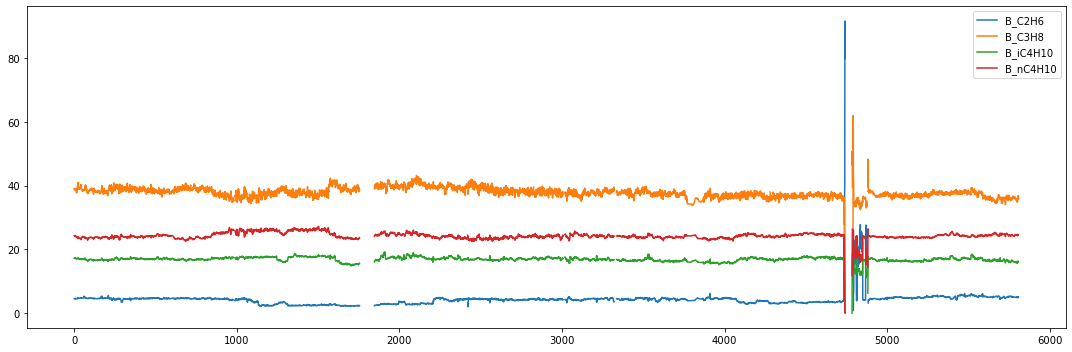

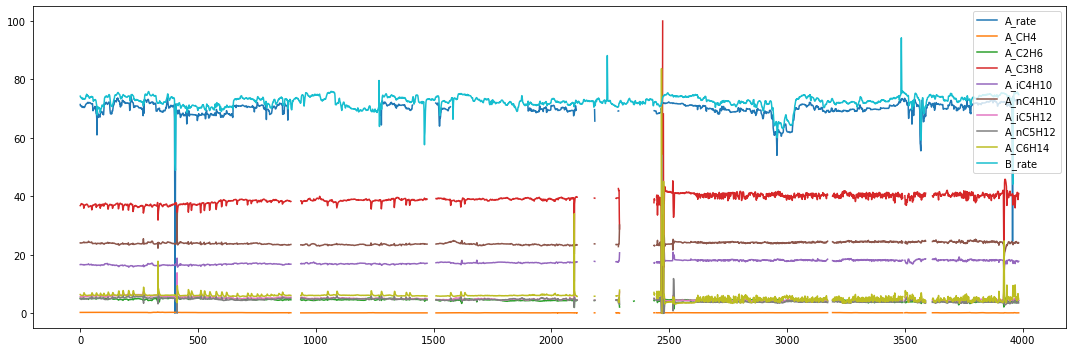

In [621]:
plt.rcParams["figure.figsize"] = (15,5)

train_features[:].plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)

train_target[:].plot()

# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)

test_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [622]:
#dict_clean = {'B_C2H6':30, 'B_C3H8':50}

In [623]:
#for i in range(1,train_target.shape[0]):
#    for j in dict_clean:
#        if train_target.loc[i,j] > dict_clean[j]:
#            train_target.loc[[i],[j]] = train_target.loc[[i-1],[j]]

## Трансформация датасета

Попробуем оценить кажущийся отклик

In [624]:
train_features[['A_rate','B_rate']]

A_rate     B_rate
0     70.855017  71.982789
1     70.826582  71.965098
2     70.809637  71.867409
3     69.994748  71.839126
4     70.072762  71.336921
...         ...        ...
5803  72.009730  74.183355
5804  71.854180  74.213066
5805  71.783273  74.144367
5806  71.717743  74.320575
5807  71.730325  74.327170

[5808 rows x 2 columns]

In [625]:
derivatives_A = pd.DataFrame()
derivatives_B = pd.DataFrame()

derivatives_A['der_A_rate']=[]
derivatives_B['der_B_rate']=[]

for i in range(train_features[['A_rate','B_rate']].shape[1]):
    for j in range(train_features[['A_rate','B_rate']].shape[0]-1):
        x = train_features[['A_rate','B_rate']].iloc[j,i]
        y = train_features[['A_rate','B_rate']].iloc[j+1,i]
        
        if i == 0:
            new_line = {'der_A_rate':(y-x)/30}
            derivatives_A = derivatives_A.append(new_line, ignore_index=True)
        else:
            new_line = {'der_B_rate':(y-x)/30}
            derivatives_B = derivatives_B.append(new_line, ignore_index=True)

In [626]:
derivatives = pd.concat([derivatives_A,derivatives_B.reset_index(drop=True)], axis=1)
derivatives

der_A_rate  der_B_rate
0      -0.000948   -0.000590
1      -0.000565   -0.003256
2      -0.027163   -0.000943
3       0.002600   -0.016740
4      -0.002479   -0.000636
...          ...         ...
5802   -0.008466    0.006174
5803   -0.005185    0.000990
5804   -0.002364   -0.002290
5805   -0.002184    0.005874
5806    0.000419    0.000220

[5807 rows x 2 columns]

In [627]:
# Сдвиг по времени 0
(derivatives['der_A_rate'] - derivatives['der_B_rate']).apply(np.abs).mean()

0.016707230655472926

In [628]:
# Сдвиг по времени 30 минут
x = derivatives['der_A_rate'][0:-1]
y = derivatives['der_B_rate'][1:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.012438913385618582

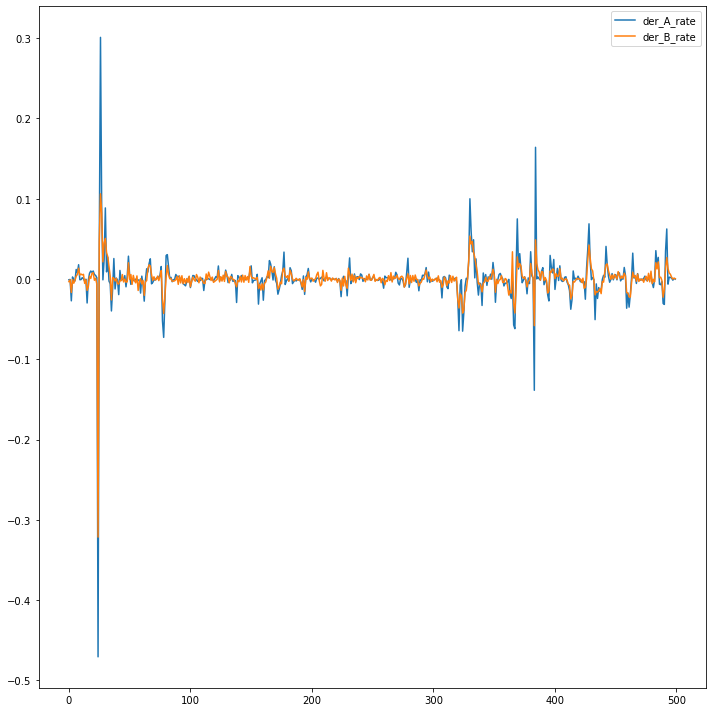

In [629]:
plt.rcParams["figure.figsize"] = (10,10)

z[0:500].plot()

# make room for tick labels
plt.tight_layout()

plt.show()

In [630]:
# Сдвиг по времени 60 минут
x = derivatives['der_A_rate'][0:-2]
y = derivatives['der_B_rate'][2:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.01659637858206412

In [631]:
# Сдвиг по времени 90 минут
x = derivatives['der_A_rate'][0:-3]
y = derivatives['der_B_rate'][3:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.0191065411244112

Кажущийся отклик по расходу: 30 минут +- 15 минут

In [632]:
der = pd.concat([train_features[['A_C3H8']],train_target[['B_C3H8']].reset_index(drop=True)], axis=1)
der

A_C3H8     B_C3H8
0           NaN  39.015486
1           NaN  39.048915
2           NaN  38.766378
3           NaN  39.069360
4           NaN  38.817579
...         ...        ...
5803  35.758852  35.539156
5804  35.877193  36.067750
5805  36.271557  36.275040
5806  36.616673  36.872917
5807  36.602453  35.860326

[5808 rows x 2 columns]

In [633]:
derivatives_A = pd.DataFrame()
derivatives_B = pd.DataFrame()

derivatives_A['der_A_C3H8']=[]
derivatives_B ['der_B_C3H8']=[]

for i in range(der[['A_C3H8','B_C3H8']].shape[1]):
    for j in range(der[['A_C3H8','B_C3H8']].shape[0]-1):
        x = der[['A_C3H8','B_C3H8']].iloc[j,i]
        y = der[['A_C3H8','B_C3H8']].iloc[j+1,i]
        
        if i == 0:
            new_line = {'der_A_C3H8':(y-x)/30}
            derivatives_A = derivatives_A.append(new_line, ignore_index=True)
        else:
            new_line = {'der_B_C3H8':(y-x)/30}
            derivatives_B = derivatives_B.append(new_line, ignore_index=True)

In [634]:
derivatives = pd.concat([derivatives_A,derivatives_B.reset_index(drop=True)], axis=1)
derivatives

der_A_C3H8  der_B_C3H8
0            NaN    0.001114
1            NaN   -0.009418
2            NaN    0.010099
3            NaN   -0.008393
4            NaN    0.009035
...          ...         ...
5802   -0.031136    0.013457
5803    0.003945    0.017620
5804    0.013145    0.006910
5805    0.011504    0.019929
5806   -0.000474   -0.033753

[5807 rows x 2 columns]

In [635]:
sum_list = []
for i in range(1, 500):
    # Сдвиг по времени 30 минут
    x = derivatives['der_A_C3H8'][0:-i]
    y = derivatives['der_B_C3H8'][i:]
    z = pd.concat([x,y.reset_index(drop=True)], axis=1)
    a = (z['der_A_C3H8'] - z['der_B_C3H8']).apply(np.abs).mean()
    sum_list.append(a)
sum_list

[0.023168620261610633,
 0.022941302908064867,
 0.023076402383681496,
 0.023007837891132844,
 0.02308520433232322,
 0.022998618400929993,
 0.023088084618765256,
 0.02302276987830654,
 0.022928015464199064,
 0.02299028303552343,
 0.023038317471129326,
 0.023005889164756127,
 0.023247246493165067,
 0.023123943988846086,
 0.02305010723768911,
 0.02292233818801306,
 0.02296416019145473,
 0.022994974688841985,
 0.022862676566483654,
 0.023232155437302518,
 0.02333265310709226,
 0.023140247833835895,
 0.023352205874189444,
 0.0234235720262994,
 0.02360569979048118,
 0.023422933359643114,
 0.02337054617889874,
 0.023408164454105863,
 0.023349254075973786,
 0.023377916986810854,
 0.0232786991291875,
 0.023475243652039013,
 0.02338073448967671,
 0.02343847016769941,
 0.023529752144963636,
 0.023228986715204677,
 0.023387703556487806,
 0.023258954950680862,
 0.023130583443004872,
 0.023063061685873035,
 0.022893299023831644,
 0.022675097163376217,
 0.02254823160925182,
 0.022650336678398185,
 0.0

In [636]:
min(sum_list)

0.022416428442448882

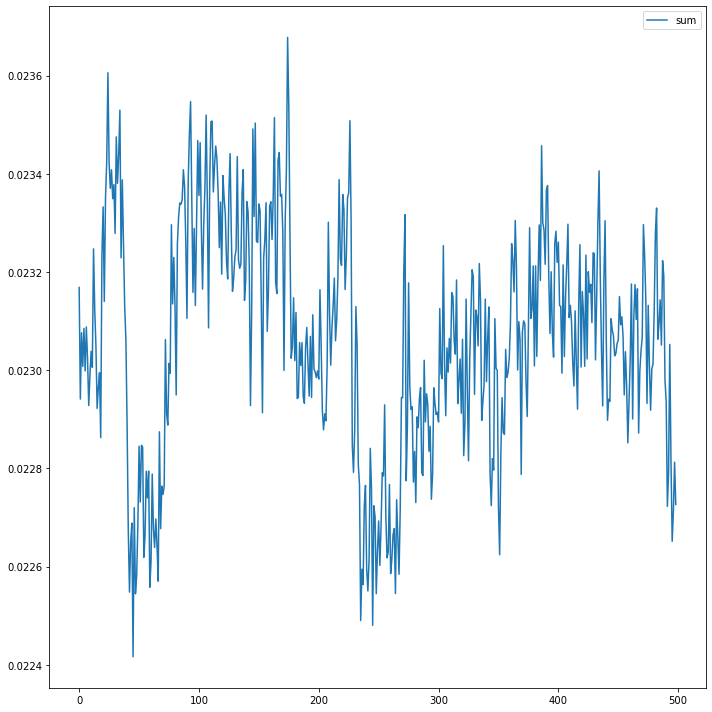

In [637]:
sum_pd = pd.DataFrame()
sum_pd['sum'] = sum_list
plt.rcParams["figure.figsize"] = (10,10)

sum_pd.plot()

# make room for tick labels
plt.tight_layout()

plt.show()

In [638]:
# Сдвиг по времени 30 минут
x = derivatives['der_A_C3H8'][0:-60]
y = derivatives['der_B_C3H8'][60:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_C3H8'] - z['der_B_C3H8']).apply(np.abs).mean()

0.02255807311418939

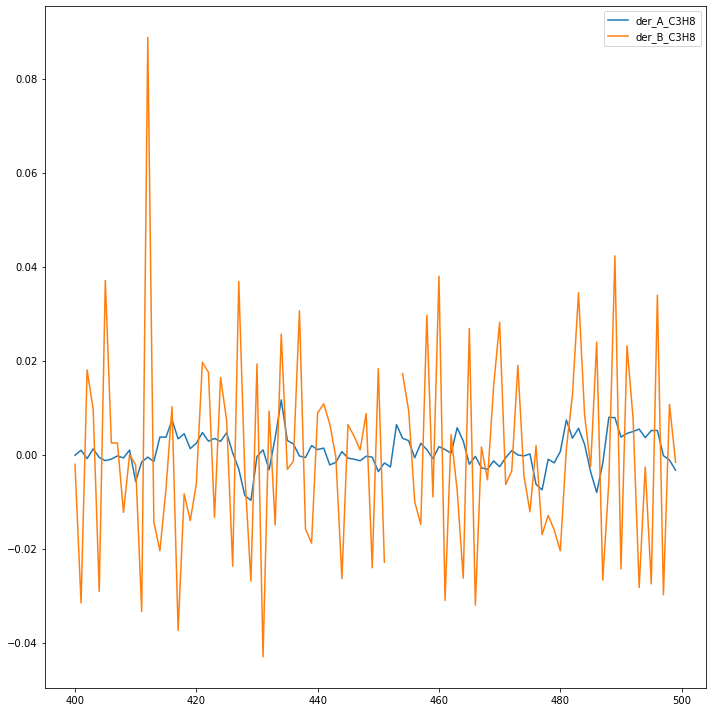

In [639]:
plt.rcParams["figure.figsize"] = (10,10)

z[400:500].plot()

# make room for tick labels
plt.tight_layout()

plt.show()

In [640]:
# Сдвиг по времени 60 минут
x = derivatives['der_A_C3H8'][0:-2]
y = derivatives['der_B_C3H8'][2:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_C3H8'] - z['der_B_C3H8']).apply(np.abs).mean()

0.022941302908064867

In [641]:
# Сдвиг по времени 60 минут
x = derivatives['der_A_C3H8'][0:-3]
y = derivatives['der_B_C3H8'][3:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_C3H8'] - z['der_B_C3H8']).apply(np.abs).mean()

0.023076402383681496

In [642]:
# Сдвиг по времени 
x = derivatives['der_A_C3H8'][0:-300]
y = derivatives['der_B_C3H8'][300:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_C3H8'] - z['der_B_C3H8']).apply(np.abs).mean()

0.022914313609018477

In [643]:
data = pd.concat([train_features,train_target.drop(['timestamp'], axis=1)], axis=1)
data.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
B_C2H6       184
B_C3H8       180
B_iC4H10     180
B_nC4H10     180
dtype: int64

In [644]:
data = data.ffill(axis = 0)
data.isnull().sum()

timestamp    0
A_rate       0
A_CH4        9
A_C2H6       9
A_C3H8       9
A_iC4H10     9
A_nC4H10     9
A_iC5H12     9
A_nC5H12     9
A_C6H14      9
B_rate       0
B_C2H6       0
B_C3H8       0
B_iC4H10     0
B_nC4H10     0
dtype: int64

In [645]:
NaNList = []
x = (data.isnull().sum(axis=1) > 0)
for i in range(x.shape[0]):
    if x[i] == True:
        NaNList.append(i)
data.drop(NaNList, axis=0, inplace=True)
data = data.reset_index(drop=True)

In [646]:
data

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 04:30:00  71.055792  0.126244  5.242957  41.941480   
1     2020-01-01 05:00:00  71.029881  0.111301  4.632455  39.198330   
2     2020-01-01 05:30:00  71.008884  0.125176  4.730933  37.874656   
3     2020-01-01 06:00:00  71.060109  0.141546  5.214231  39.763493   
4     2020-01-01 06:30:00  71.067865  0.143911  5.440833  41.616510   
...                   ...        ...       ...       ...        ...   
5794  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5795  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5796  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5797  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5798  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6  \
0     17.064213  23.205953  4.184848  4.062079  4.110170  71.389674  4.532649   
1     17.440245  24.331520  4.615703  4.545702  5.072316  71.792506  4.578543   
2     17.353362  24.567692  4.847911  4.818913  5.626975  71.939558  4.642879   
3     17.098163  23.758240  4.512244  4.429068  5.021207  72.124690  4.549837   
4     16.964787  23.121613  4.212636  4.088066  4.347822  72.278288  4.556611   
...         ...        ...       ...       ...       ...        ...       ...   
5794  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  4.816865   
5795  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  4.993286   
5796  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  5.101574   
5797  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  5.210675   
5798  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  5.136487   

         B_C3H8   B_iC4H10   B_nC4H10  
0     38.604149  17.238489  24.275393  
1     38.510623  17.193441  24.242152  
2     39.124029  17.301609  24.211492  
3     38.247333  17.118282  24.044074  
4     37.985776  17.038811  23.931490  
...         ...        ...        ...  
5794  35.539156  16.269938  24.770377  
5795  36.067750  16.317757  24.729847  
5796  36.275040  16.295460  24.629889  
5797  36.872917  16.336359  24.438236  
5798  35.860326  16.101509  24.426845  

[5799 rows x 15 columns]

In [647]:
data_prev = data
data = data.rolling(25, min_periods=0).mean()

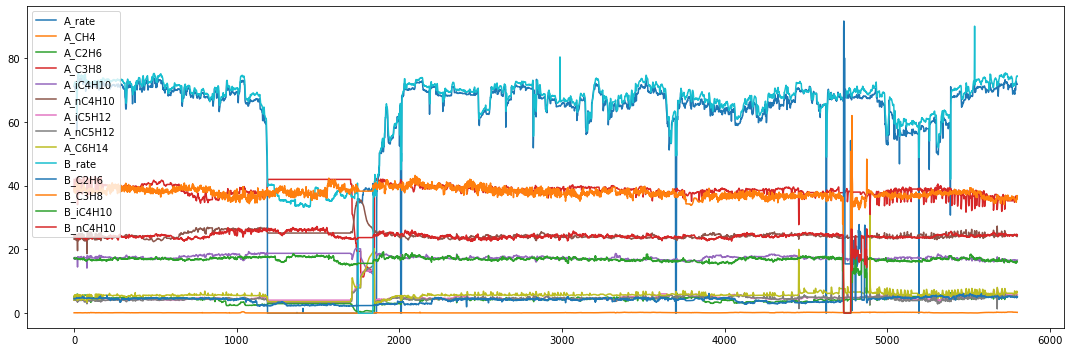

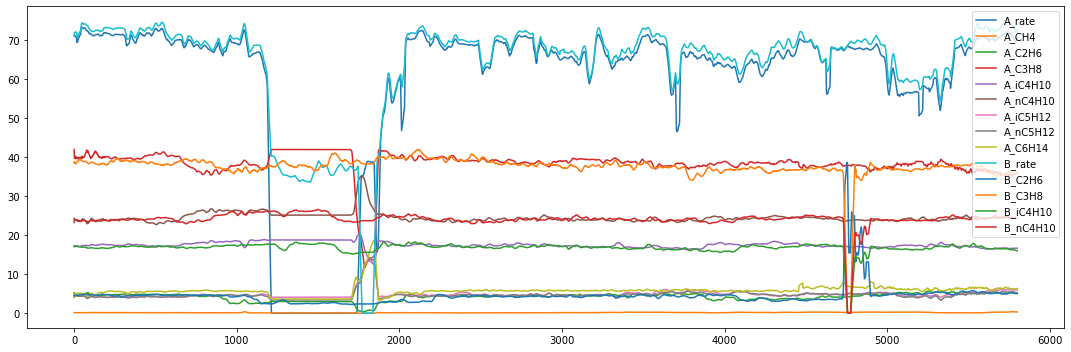

In [648]:
plt.rcParams["figure.figsize"] = (15,5)
data_prev[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[:].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

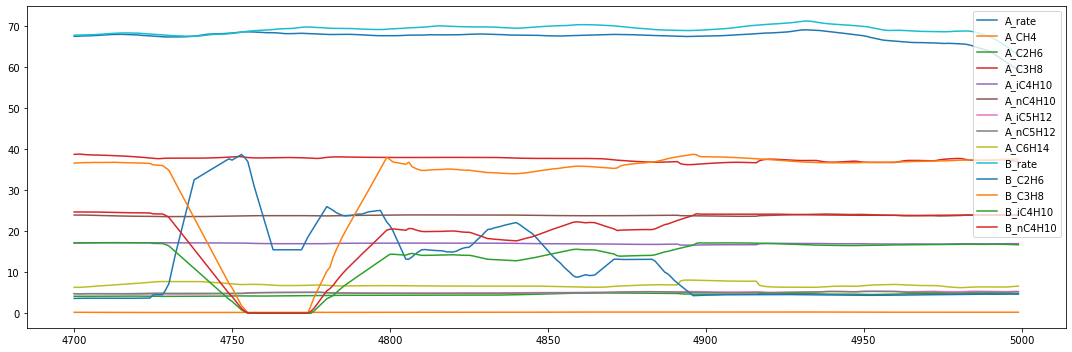

In [649]:
plt.rcParams["figure.figsize"] = (15,5)
data[4700:5000].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [650]:
data[data[:] < 0].isnull().sum()

A_rate      5799
A_CH4       5799
A_C2H6      5799
A_C3H8      5799
A_iC4H10    5799
A_nC4H10    5799
A_iC5H12    5799
A_nC5H12    5799
A_C6H14     5799
B_rate      5799
B_C2H6      5799
B_C3H8      5799
B_iC4H10    5799
B_nC4H10    5799
dtype: int64

In [651]:
data['timestamp'] = data_prev['timestamp']
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.055792  0.126244  5.242957  41.941480  17.064213  23.205953   
1     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
2     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
3     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
4     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
...         ...       ...       ...        ...        ...        ...   
5794  70.011434  0.311899  5.102604  36.059145  16.656132  24.461361   
5795  70.138927  0.307879  5.083436  36.085269  16.650851  24.440942   
5796  70.258695  0.306373  5.077539  36.098835  16.642139  24.416459   
5797  70.376650  0.304539  5.073333  36.125671  16.635892  24.392833   
5798  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.184848  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489   
1     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
2     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
3     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
4     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
...        ...       ...       ...        ...       ...        ...        ...   
5794  5.904529  5.201483  6.246366  72.121189  5.010871  35.756568  15.997002   
5795  5.904031  5.198986  6.272643  72.237662  5.010089  35.757599  16.005038   
5796  5.901267  5.200797  6.300740  72.362225  5.013248  35.766447  16.013172   
5797  5.894854  5.196923  6.320211  72.481486  5.020496  35.803156  16.026852   
5798  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10            timestamp  
0     24.275393  2020-01-01 04:30:00  
1     24.258773  2020-01-01 05:00:00  
2     24.243013  2020-01-01 05:30:00  
3     24.193278  2020-01-01 06:00:00  
4     24.140920  2020-01-01 06:30:00  
...         ...                  ...  
5794  24.464644  2020-04-30 21:30:00  
5795  24.481749  2020-04-30 22:00:00  
5796  24.497347  2020-04-30 22:30:00  
5797  24.507734  2020-04-30 23:00:00  
5798  24.517125  2020-04-30 23:30:00  

[5799 rows x 15 columns]

In [652]:
monthList =[]
for i in data['timestamp']:
    monthList.append(int(str(i)[5:7]))

In [653]:
data['month'] = monthList

In [654]:
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.055792  0.126244  5.242957  41.941480  17.064213  23.205953   
1     71.042837  0.118773  4.937706  40.569905  17.252229  23.768737   
2     71.031519  0.120907  4.868781  39.671489  17.285940  24.035055   
3     71.038667  0.126067  4.955144  39.694490  17.238996  23.965851   
4     71.044506  0.129636  5.052282  40.078894  17.184154  23.797004   
...         ...       ...       ...        ...        ...        ...   
5794  70.011434  0.311899  5.102604  36.059145  16.656132  24.461361   
5795  70.138927  0.307879  5.083436  36.085269  16.650851  24.440942   
5796  70.258695  0.306373  5.077539  36.098835  16.642139  24.416459   
5797  70.376650  0.304539  5.073333  36.125671  16.635892  24.392833   
5798  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.184848  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489   
1     4.400275  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965   
2     4.549487  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513   
3     4.540177  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955   
4     4.474668  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127   
...        ...       ...       ...        ...       ...        ...        ...   
5794  5.904529  5.201483  6.246366  72.121189  5.010871  35.756568  15.997002   
5795  5.904031  5.198986  6.272643  72.237662  5.010089  35.757599  16.005038   
5796  5.901267  5.200797  6.300740  72.362225  5.013248  35.766447  16.013172   
5797  5.894854  5.196923  6.320211  72.481486  5.020496  35.803156  16.026852   
5798  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10            timestamp  month  
0     24.275393  2020-01-01 04:30:00      1  
1     24.258773  2020-01-01 05:00:00      1  
2     24.243013  2020-01-01 05:30:00      1  
3     24.193278  2020-01-01 06:00:00      1  
4     24.140920  2020-01-01 06:30:00      1  
...         ...                  ...    ...  
5794  24.464644  2020-04-30 21:30:00      4  
5795  24.481749  2020-04-30 22:00:00      4  
5796  24.497347  2020-04-30 22:30:00      4  
5797  24.507734  2020-04-30 23:00:00      4  
5798  24.517125  2020-04-30 23:30:00      4  

[5799 rows x 16 columns]

In [655]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'timestamp', 'month'],
      dtype='object')

In [656]:
#g = sns.PairGrid(data)
#g.map(sns.scatterplot)

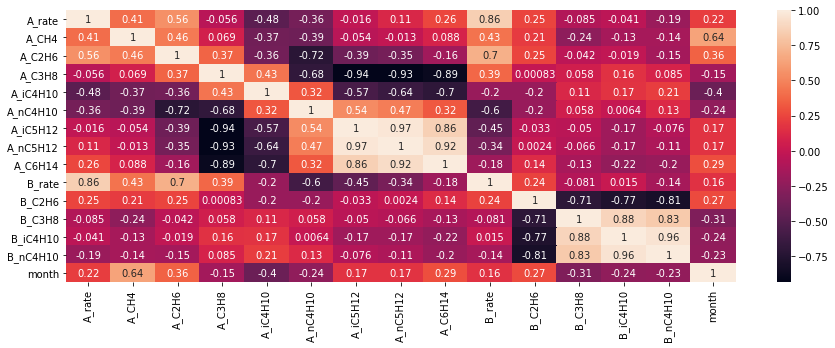

In [657]:
sns.heatmap(data.corr(), annot=True)

По [1] выпишем плотности сжиженных газов при 0 град Цельсия:

In [658]:
# кг/м3
ro_CH4 = 300.0 #Не нашел, указал из логических соображений
ro_C2H6 = 404.8
ro_C3H8 = 529.7
ro_iC4H10 = 581.0
ro_nC4H10 = 601.0
ro_iC5H12 = 639.2
ro_nC5H12 = 645.5
ro_C6H14 = 677.2

по [2] стр 65 выпишем динамическую вязкость сжиженных газов при 0 град Цельсия:

In [659]:
# Па*с
mu_CH4 = 10e-6 #Не нашел, указал из логических соображений
mu_C2H6 = 65e-6
mu_C3H8 = 140e-6
mu_iC4H10 = 225e-6
mu_nC4H10 = 215e-6
mu_iC5H12 = 285e-6
mu_nC5H12 = 295e-6
mu_C6H14 = 360e-6 #Не нашел, указал из логических соображений

по [3] выпишем молярные массы:

In [660]:
# кг/кмоль
M_CH4 = 16.04
M_C2H6 = 30.07
M_C3H8 = 44.1
M_iC4H10 = 58.12
M_nC4H10 = 58.12
M_iC5H12 = 72.15
M_nC5H12 = 72.15
M_C6H14 = 86.18

In [661]:
data['G_A_CH4'] = data['A_rate'] * data['A_CH4'] / 100
data['G_A_C2H6'] = data['A_rate'] * data['A_C2H6'] / 100
data['G_A_C3H8'] = data['A_rate'] * data['A_C3H8'] / 100
data['G_A_iC4H10'] = data['A_rate'] * data['A_iC4H10'] / 100
data['G_A_nC4H10'] = data['A_rate'] * data['A_nC4H10'] / 100
data['G_A_iC5H12'] = data['A_rate'] * data['A_iC5H12'] / 100
data['G_A_nC5H12'] = data['A_rate'] * data['A_nC5H12'] / 100
data['G_A_C6H14'] = data['A_rate'] * data['A_C6H14'] / 100

data['G_B_C2H6'] = data['B_rate'] * data['B_C2H6'] / 100
data['G_B_C3H8'] = data['B_rate'] * data['B_C3H8'] / 100
data['G_B_iC4H10'] = data['B_rate'] * data['B_iC4H10'] / 100
data['G_B_nC4H10'] = data['B_rate'] * data['B_nC4H10'] / 100

In [662]:
data['ro_mix_A'] = ((data['A_CH4'] / 100 / ro_CH4) + (data['A_C2H6'] / 100 / ro_C2H6) 
                  + (data['A_C3H8'] / 100 / ro_C3H8) + (data['A_iC4H10'] / 100 / ro_iC4H10) 
                  + (data['A_nC4H10'] / 100 / ro_nC4H10) + (data['A_iC5H12'] / 100 / ro_iC5H12)
                  + (data['A_nC5H12'] / 100 / ro_nC5H12) + (data['A_C6H14'] / 100 / ro_C6H14))**-1

In [663]:
data['mu_mix_A'] = (((data['A_CH4'] / 100) * (data['ro_mix_A'] / ro_CH4)) / mu_CH4 
                  + ((data['A_C2H6'] / 100) * (data['ro_mix_A'] / ro_C2H6)) / mu_C2H6 
                  + ((data['A_C3H8'] / 100) * (data['ro_mix_A'] / ro_C3H8)) / mu_C3H8
                  + ((data['A_iC4H10'] / 100) * (data['ro_mix_A'] / ro_iC4H10)) / mu_iC4H10
                  + ((data['A_nC4H10'] / 100) * (data['ro_mix_A'] / ro_nC4H10)) / mu_nC4H10
                  + ((data['A_iC5H12'] / 100) * (data['ro_mix_A'] / ro_iC5H12)) / mu_iC5H12
                  + ((data['A_nC5H12'] / 100) * (data['ro_mix_A'] / ro_nC5H12)) / mu_nC5H12
                  + ((data['A_C6H14'] / 100) * (data['ro_mix_A'] / ro_C6H14)) / mu_C6H14)**-1

In [664]:
data['w_A'] = (4*data['A_rate']*0.278)/(3.14*data['ro_mix_A']*0.16)
data['Re_A'] = (4*data['A_rate']*0.278)/(3.14*0.4*data['mu_mix_A'])

In [665]:
data['A_rate**2'] = data['A_rate']**2
data['sqrt_A_rate'] = data['A_rate'].apply(m.sqrt)
data['e**A_rate'] = data['A_rate'].apply(m.exp)
data['lg_A_rate'] = data['A_rate'].apply(m.log10)
data['ln_A_rate'] = data['A_rate'].apply(m.log)

data['B_rate**2'] = data['B_rate']**2
data['sqrt_B_rate'] = data['B_rate'].apply(m.sqrt)
data['e**B_rate'] = data['B_rate'].apply(m.exp)
#data['lg_B_rate'] = data['B_rate'].apply(m.log10)
#data['ln_B_rate'] = data['B_rate'].apply(m.log)

data['Re_A**2'] = data['Re_A']**2
data['sqrt_Re_A'] = data['Re_A'].apply(m.sqrt)
#data['e**Re_A'] = data['Re_A'].apply(m.exp)
data['lg_Re_A'] = data['Re_A'].apply(m.log10)
data['ln_Re_A'] = data['Re_A'].apply(m.log)

In [666]:
data.head()

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.055792  0.126244  5.242957  41.941480  17.064213  23.205953  4.184848   
1  71.042837  0.118773  4.937706  40.569905  17.252229  23.768737  4.400275   
2  71.031519  0.120907  4.868781  39.671489  17.285940  24.035055  4.549487   
3  71.038667  0.126067  4.955144  39.694490  17.238996  23.965851  4.540177   
4  71.044506  0.129636  5.052282  40.078894  17.184154  23.797004  4.474668   

   A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.062079  4.110170  71.389674  4.532649  38.604149  17.238489  24.275393   
1  4.303891  4.591243  71.591090  4.555596  38.557386  17.215965  24.258773   
2  4.475565  4.936487  71.707246  4.584690  38.746267  17.244513  24.243013   
3  4.463941  4.957667  71.811607  4.575977  38.621533  17.212955  24.193278   
4  4.388766  4.835698  71.904943  4.572104  38.494382  17.178127  24.140920   

             timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  2020-01-01 04:30:00      1  0.089704  3.725424  29.801851   12.125112   
1  2020-01-01 05:00:00      1  0.084380  3.507886  28.822011   12.256473   
2  2020-01-01 05:30:00      1  0.085882  3.458369  28.179261   12.278466   
3  2020-01-01 06:00:00      1  0.089556  3.520068  28.198436   12.246353   
4  2020-01-01 06:30:00      1  0.092099  3.589369  28.473852   12.208397   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   16.489174    2.973577    2.886343   2.920514  3.235844  27.559376   
1   16.885985    3.126080    3.057606   3.261749  3.261401  27.603653   
2   17.072465    3.231570    3.179062   3.506462  3.287555  27.783881   
3   17.025021    3.225281    3.171124   3.521861  3.286083  27.734744   
4   16.906464    3.179006    3.117977   3.435498  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.306501   17.330124  557.275650  0.000152  0.282218  413051.697732   
1   12.325097   17.367120  559.415129  0.000155  0.281087  406691.601290   
2   12.365565   17.383997  560.509094  0.000156  0.280494  404402.122607   
3   12.360900   17.373582  560.268157  0.000155  0.280643  405816.722617   
4   12.351922   17.358515  559.631119  0.000154  0.280985  407882.237062   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5048.925626     8.429460  7.230004e+30   1.851599   4.263465  5096.485564   
1  5047.084656     8.428691  7.136939e+30   1.851520   4.263283  5125.284167   
2  5045.476739     8.428020  7.056623e+30   1.851451   4.263124  5141.929142   
3  5046.492171     8.428444  7.107240e+30   1.851495   4.263224  5156.906896   
4  5047.321876     8.428790  7.148864e+30   1.851531   4.263307  5170.320863   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  
0     8.449241  1.009582e+31  1.706117e+11  642.690982  5.616004  12.931328  
1     8.461152  1.234853e+31  1.653981e+11  637.723766  5.609265  12.915810  
2     8.468013  1.386952e+31  1.635411e+11  635.926193  5.606813  12.910165  
3     8.474173  1.539518e+31  1.646872e+11  637.037458  5.608330  12.913657  
4     8.479678  1.690130e+31  1.663679e+11  638.656588  5.610535  12.918734

In [667]:
data.loc[[0,]]

A_rate     A_CH4    A_C2H6    A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  71.055792  0.126244  5.242957  41.94148  17.064213  23.205953  4.184848   

   A_nC5H12  A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.062079  4.11017  71.389674  4.532649  38.604149  17.238489  24.275393   

             timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  2020-01-01 04:30:00      1  0.089704  3.725424  29.801851   12.125112   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   16.489174    2.973577    2.886343   2.920514  3.235844  27.559376   

   G_B_iC4H10  G_B_nC4H10   ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.306501   17.330124  557.27565  0.000152  0.282218  413051.697732   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5048.925626      8.42946  7.230004e+30   1.851599   4.263465  5096.485564   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  
0     8.449241  1.009582e+31  1.706117e+11  642.690982  5.616004  12.931328

In [668]:
data.loc[[60,]]

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
60  72.967492  0.119173  4.599518  39.962582  17.333724  24.049195  4.444854   

    A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  B_nC4H10  \
60  4.410287  5.024882  74.008719  4.865921  38.792142  16.941776  23.80514   

              timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
60  2020-01-02 10:30:00      1  0.086957  3.356153  29.159694   12.647984   

    G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
60   17.548094    3.243298    3.218076    3.66653  3.601206  28.709568   

    G_B_iC4H10  G_B_nC4H10   ro_mix_A  mu_mix_A       w_A          Re_A  \
60   12.538392   17.617879  560.98055  0.000156  0.287897  413249.04571   

      A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
60  5324.254821     8.542101  4.890789e+31   1.863129   4.290014  5477.290431   

    sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  
60     8.602832  1.385409e+32  1.707748e+11  642.844496  5.616212  12.931806

In [669]:
Ct_A = pd.DataFrame({'Ct_A_C2H6':[np.nan]*60,'Ct_A_C3H8':[np.nan]*60,'Ct_A_iC4H10':[np.nan]*60,
                     'Ct_A_nC4H10':[np.nan]*60})

Cx_A = pd.DataFrame({'Cx_A_C2H6':[np.nan]*60,'Cx_A_C3H8':[np.nan]*60,'Cx_A_iC4H10':[np.nan]*60,
                     'Cx_A_nC4H10':[np.nan]*60})

G = data[['G_A_C2H6', 'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10',
          'G_B_C2H6', 'G_B_C3H8','G_B_iC4H10', 'G_B_nC4H10']]

In [670]:
for i in range(G.shape[0]-60):
    new_line = {}
    for j in range(G.shape[1]-4):
        x = G.iloc[i,j]
        y = G.iloc[i+60,j]
        new_line.update({Ct_A .columns[j]:(y-x)})
    Ct_A = Ct_A.append(new_line, ignore_index=True)

In [671]:
G.head()

G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_B_C2H6   G_B_C3H8  \
0  3.725424  29.801851   12.125112   16.489174  3.235844  27.559376   
1  3.507886  28.822011   12.256473   16.885985  3.261401  27.603653   
2  3.458369  28.179261   12.278466   17.072465  3.287555  27.783881   
3  3.520068  28.198436   12.246353   17.025021  3.286083  27.734744   
4  3.589369  28.473852   12.208397   16.906464  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10  
0   12.306501   17.330124  
1   12.325097   17.367120  
2   12.365565   17.383997  
3   12.360900   17.373582  
4   12.351922   17.358515

In [672]:
Ct_A 

Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  Ct_A_nC4H10
0           NaN        NaN          NaN          NaN
1           NaN        NaN          NaN          NaN
2           NaN        NaN          NaN          NaN
3           NaN        NaN          NaN          NaN
4           NaN        NaN          NaN          NaN
...         ...        ...          ...          ...
5794  -0.062403  -0.507875    -0.367431    -0.528223
5795  -0.071630  -0.429562    -0.352229    -0.530489
5796  -0.073484  -0.354426    -0.339038    -0.537682
5797  -0.074482  -0.247294    -0.319786    -0.542884
5798  -0.081757  -0.158502    -0.299483    -0.540273

[5799 rows x 4 columns]

In [673]:
for i in range(G.shape[0]-60):
    new_line = {}
    for j in range(G.shape[1]-4):
        x = G.iloc[i,j]
        y = G.iloc[i,j+4]
        new_line.update({Cx_A .columns[j]:(y-x)})
    Cx_A = Cx_A.append(new_line, ignore_index=True)

In [674]:
G.head()

G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_B_C2H6   G_B_C3H8  \
0  3.725424  29.801851   12.125112   16.489174  3.235844  27.559376   
1  3.507886  28.822011   12.256473   16.885985  3.261401  27.603653   
2  3.458369  28.179261   12.278466   17.072465  3.287555  27.783881   
3  3.520068  28.198436   12.246353   17.025021  3.286083  27.734744   
4  3.589369  28.473852   12.208397   16.906464  3.287569  27.679363   

   G_B_iC4H10  G_B_nC4H10  
0   12.306501   17.330124  
1   12.325097   17.367120  
2   12.365565   17.383997  
3   12.360900   17.373582  
4   12.351922   17.358515

In [675]:
Cx_A

Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10
0           NaN        NaN          NaN          NaN
1           NaN        NaN          NaN          NaN
2           NaN        NaN          NaN          NaN
3           NaN        NaN          NaN          NaN
4           NaN        NaN          NaN          NaN
...         ...        ...          ...          ...
5794   0.065118   1.116313     0.302852     0.797466
5795   0.061315   1.155294     0.286835     0.778843
5796   0.056553   1.181358     0.273169     0.754738
5797   0.056916   1.218438     0.269037     0.729642
5798   0.061586   1.278544     0.269229     0.704578

[5799 rows x 4 columns]

In [676]:
w = pd.DataFrame({'w_prev':[np.nan]*60})
j = pd.DataFrame({'w_prev':data['w_A']})
w = pd.concat([w,j], axis=0)
w = w.reset_index(drop=True)
a = [5799 + i for i in range(0, 60)]
for i in a:
    w.drop(i, axis=0, inplace=True)
w = w.reset_index(drop=True)
w

w_prev
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
...        ...
5794  0.282945
5795  0.283043
5796  0.283163
5797  0.283256
5798  0.283354

[5799 rows x 1 columns]

In [677]:
x = data
y = pd.concat([Cx_A,Ct_A,w], axis=1)
data = pd.concat([data,y], axis=1)

In [678]:
for i in range(0,60):
    data.drop(i, axis=0, inplace=True)
data = data.reset_index(drop=True)

In [679]:
data.head()

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  A_iC5H12  \
0  72.967492  0.119173  4.599518  39.962582  17.333724  24.049195  4.444854   
1  72.989180  0.117846  4.589412  39.989236  17.349545  24.046292  4.433048   
2  73.010305  0.116845  4.586101  39.982317  17.368136  24.050391  4.425914   
3  73.024849  0.117339  4.623026  40.049742  17.373969  24.010670  4.405003   
4  73.052314  0.118385  4.677693  40.236532  17.369795  23.926325  4.364374   

   A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10  \
0  4.410287  5.024882  74.008719  4.865921  38.792142  16.941776  23.805140   
1  4.402328  5.016986  74.029338  4.864940  38.785711  16.940123  23.815175   
2  4.397513  5.017951  74.041296  4.872388  38.839969  16.943196  23.810835   
3  4.372576  4.992923  74.060868  4.872920  38.846582  16.942900  23.814509   
4  4.326111  4.925893  74.079009  4.874566  38.861779  16.940374  23.808953   

             timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  2020-01-02 10:30:00      1  0.086957  3.356153  29.159694   12.647984   
1  2020-01-02 11:00:00      1  0.086015  3.349774  29.187816   12.663290   
2  2020-01-02 11:30:00      1  0.085309  3.348326  29.191211   12.680529   
3  2020-01-02 12:00:00      1  0.085687  3.375958  29.246264   12.687315   
4  2020-01-02 12:30:00      1  0.086483  3.417163  29.393718   12.689038   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   17.548094    3.243298    3.218076   3.666530  3.601206  28.709568   
1   17.551191    3.235645    3.213223   3.661857  3.601483  28.712805   
2   17.559263    3.231373    3.210637   3.663621  3.607580  28.757616   
3   17.533756    3.216747    3.193067   3.646075  3.608927  28.770116   
4   17.478734    3.188276    3.160324   3.598479  3.611030  28.788421   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.538392   17.617879  560.980550  0.000156  0.287897  413249.045710   
1   12.540661   17.630216  560.977796  0.000156  0.287984  413185.999580   
2   12.544962   17.629851  560.987096  0.000156  0.288062  413153.130907   
3   12.548059   17.637232  560.811540  0.000156  0.288210  413782.713116   
4   12.549261   17.637436  560.468582  0.000156  0.288495  414960.599962   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5324.254821     8.542101  4.890789e+31   1.863129   4.290014  5477.290431   
1  5327.420468     8.543371  4.998024e+31   1.863258   4.290311  5480.342919   
2  5330.504588     8.544607  5.104726e+31   1.863384   4.290601  5482.113492   
3  5332.628534     8.545458  5.179512e+31   1.863471   4.290800  5485.012229   
4  5336.640645     8.547065  5.323743e+31   1.863634   4.291176  5487.699574   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  \
0     8.602832  1.385409e+32  1.707748e+11  642.844496  5.616212  12.931806   
1     8.604030  1.414272e+32  1.707227e+11  642.795457  5.616146  12.931653   
2     8.604725  1.431285e+32  1.706955e+11  642.769890  5.616111  12.931574   
3     8.605862  1.459575e+32  1.712161e+11  643.259445  5.616772  12.933096   
4     8.606916  1.486294e+32  1.721923e+11  644.174355  5.618007  12.935939   

   Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  \
0  -0.489581  -2.242475     0.181389     0.840950  -0.369272  -0.642157   
1  -0.246485  -1.218358     0.068624     0.481135  -0.158112   0.365804   
2  -0.170814  -0.395380     0.087099     0.311532  -0.110043   1.011950   
3  -0.233986  -0.463693     0.114547     0.348560  -0.144110   1.047828   
4  -0.301800  -0.794489     0.143525     0.452051  -0.172206   0.919865   

   Ct_A_iC4H10  Ct_A_nC4H10    w_prev  
0     0.522872     1.058920  0.282218  
1     0.406817     0.665206  0.281087  
2     0.402063     0.486799  0.280494  
3     0.440962     0.508734  0.280643  
4     0.480640     0.572270  0.280985

In [680]:
data['Cx_A_C2H6**2'] = data['Cx_A_C2H6']**2
data['Cx_A_C3H8**2'] = data['Cx_A_C3H8']**2
data['Cx_A_iC4H10**2'] = data['Cx_A_iC4H10']**2
data['Cx_A_nC4H10**2'] = data['Cx_A_nC4H10']**2

data['E_C2H6'] = (data['Ct_A_C2H6'] + data['w_prev'] * data['Cx_A_C2H6'])/ data['Cx_A_C2H6**2']
data['E_C3H8'] = (data['Ct_A_C3H8'] + data['w_prev'] * data['Cx_A_C3H8'])/ data['Cx_A_C3H8**2']
data['E_iC4H10'] = (data['Ct_A_iC4H10'] + data['w_prev'] * data['Cx_A_iC4H10'])/ data['Cx_A_iC4H10**2']
data['E_nC4H10'] = (data['Ct_A_nC4H10'] + data['w_prev'] * data['Cx_A_nC4H10'])/ data['Cx_A_nC4H10**2']

data['Pe_ef_C2H6'] = data['w_prev'] / data['E_C2H6']
data['Pe_ef_C3H8'] = data['w_prev'] / data['E_C3H8']
data['Pe_ef_iC4H10'] = data['w_prev'] / data['E_iC4H10']
data['Pe_ef_nC4H10'] = data['w_prev'] / data['E_nC4H10']

In [681]:
data['Pe_ef_C2H6**2'] = data['Pe_ef_C2H6']**2
#data['sqrt_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.sqrt)
#data['e**Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.exp)
#data['lg_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.log10)
#data['ln_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.log)

data['Pe_ef_C3H8**2'] = data['Pe_ef_C3H8']**2
#data['sqrt_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.sqrt)
#data['e**Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.exp)
#data['lg_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.log10)
#data['ln_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.log)

data['Pe_ef_iC4H10**2'] = data['Pe_ef_iC4H10']**2
#data['sqrt_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.sqrt)
#data['e**Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.exp)
#data['lg_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log10)
#data['ln_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log)

data['Pe_ef_iC4H10**2'] = data['Pe_ef_iC4H10']**2
#data['sqrt_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.sqrt)
#data['e**Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.exp)
#data['lg_Pe_ef_iC4H10e'] = data['Pe_ef_iC4H10'].apply(m.log10)
#data['ln_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log)

In [682]:
data

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     72.967492  0.119173  4.599518  39.962582  17.333724  24.049195   
1     72.989180  0.117846  4.589412  39.989236  17.349545  24.046292   
2     73.010305  0.116845  4.586101  39.982317  17.368136  24.050391   
3     73.024849  0.117339  4.623026  40.049742  17.373969  24.010670   
4     73.052314  0.118385  4.677693  40.236532  17.369795  23.926325   
...         ...       ...       ...        ...        ...        ...   
5734  70.011434  0.311899  5.102604  36.059145  16.656132  24.461361   
5735  70.138927  0.307879  5.083436  36.085269  16.650851  24.440942   
5736  70.258695  0.306373  5.077539  36.098835  16.642139  24.416459   
5737  70.376650  0.304539  5.073333  36.125671  16.635892  24.392833   
5738  70.488888  0.302244  5.064459  36.147132  16.632641  24.377125   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     4.444854  4.410287  5.024882  74.008719  4.865921  38.792142  16.941776   
1     4.433048  4.402328  5.016986  74.029338  4.864940  38.785711  16.940123   
2     4.425914  4.397513  5.017951  74.041296  4.872388  38.839969  16.943196   
3     4.405003  4.372576  4.992923  74.060868  4.872920  38.846582  16.942900   
4     4.364374  4.326111  4.925893  74.079009  4.874566  38.861779  16.940374   
...        ...       ...       ...        ...       ...        ...        ...   
5734  5.904529  5.201483  6.246366  72.121189  5.010871  35.756568  15.997002   
5735  5.904031  5.198986  6.272643  72.237662  5.010089  35.757599  16.005038   
5736  5.901267  5.200797  6.300740  72.362225  5.013248  35.766447  16.013172   
5737  5.894854  5.196923  6.320211  72.481486  5.020496  35.803156  16.026852   
5738  5.890294  5.194408  6.336124  72.601981  5.024778  35.786361  16.030659   

       B_nC4H10            timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  \
0     23.805140  2020-01-02 10:30:00      1  0.086957  3.356153  29.159694   
1     23.815175  2020-01-02 11:00:00      1  0.086015  3.349774  29.187816   
2     23.810835  2020-01-02 11:30:00      1  0.085309  3.348326  29.191211   
3     23.814509  2020-01-02 12:00:00      1  0.085687  3.375958  29.246264   
4     23.808953  2020-01-02 12:30:00      1  0.086483  3.417163  29.393718   
...         ...                  ...    ...       ...       ...        ...   
5734  24.464644  2020-04-30 21:30:00      4  0.218365  3.572406  25.245525   
5735  24.481749  2020-04-30 22:00:00      4  0.215943  3.565468  25.309821   
5736  24.497347  2020-04-30 22:30:00      4  0.215254  3.567413  25.362570   
5737  24.507734  2020-04-30 23:00:00      4  0.214325  3.570442  25.424037   
5738  24.517125  2020-04-30 23:30:00      4  0.213048  3.569881  25.479712   

      G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6  \
0      12.647984   17.548094    3.243298    3.218076   3.666530  3.601206   
1      12.663290   17.551191    3.235645    3.213223   3.661857  3.601483   
2      12.680529   17.559263    3.231373    3.210637   3.663621  3.607580   
3      12.687315   17.533756    3.216747    3.193067   3.646075  3.608927   
4      12.689038   17.478734    3.188276    3.160324   3.598479  3.611030   
...          ...         ...         ...         ...        ...       ...   
5734   11.661197   17.125750    4.133846    3.641633   4.373171  3.613900   
5735   11.678729   17.142614    4.141024    3.646513   4.399564  3.619171   
5736   11.692550   17.154685    4.146153    3.654012   4.426818  3.627698   
5737   11.707783   17.166859    4.148601    3.657421   4.447953  3.638930   
5738   11.724163   17.183164    4.152003    3.661481   4.466263  3.648088   

       G_B_C3H8  G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A  \
0     28.709568   12.538392   17.617879  560.980550  0.000156  0.287897   
1     28.712805   12.540661   17.630216  560.977796  0.000156  0.287984   
2     28.757616   12.544962   17.629851  560.987096  0.000156  0.288062   
3     28.

In [683]:
last_line = data[-60:]

In [684]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'timestamp', 'month', 'G_A_CH4', 'G_A_C2H6',
       'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12',
       'G_A_C6H14', 'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10',
       'ro_mix_A', 'mu_mix_A', 'w_A', 'Re_A', 'A_rate**2', 'sqrt_A_rate',
       'e**A_rate', 'lg_A_rate', 'ln_A_rate', 'B_rate**2', 'sqrt_B_rate',
       'e**B_rate', 'Re_A**2', 'sqrt_Re_A', 'lg_Re_A', 'ln_Re_A', 'Cx_A_C2H6',
       'Cx_A_C3H8', 'Cx_A_iC4H10', 'Cx_A_nC4H10', 'Ct_A_C2H6', 'Ct_A_C3H8',
       'Ct_A_iC4H10', 'Ct_A_nC4H10', 'w_prev', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
       'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10',
       'E_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C3H8', 'Pe_ef_iC4H10', 'Pe_ef_nC4H10',
       'Pe_ef_C2H6**2', 'Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],
      dtype='object')

In [685]:
x = data.drop(labels=['timestamp','B_C2H6','B_C3H8', 'B_iC4H10','B_nC4H10',
                      'G_B_C2H6','G_B_C3H8', 'G_B_iC4H10','G_B_nC4H10'], axis=1)

y = data[['B_C2H6','B_C3H8', 'B_iC4H10','B_nC4H10', 
                'G_B_C2H6','G_B_C3H8', 'G_B_iC4H10','G_B_nC4H10']]

In [686]:
#g = sns.PairGrid(data)
#g.map(sns.scatterplot)

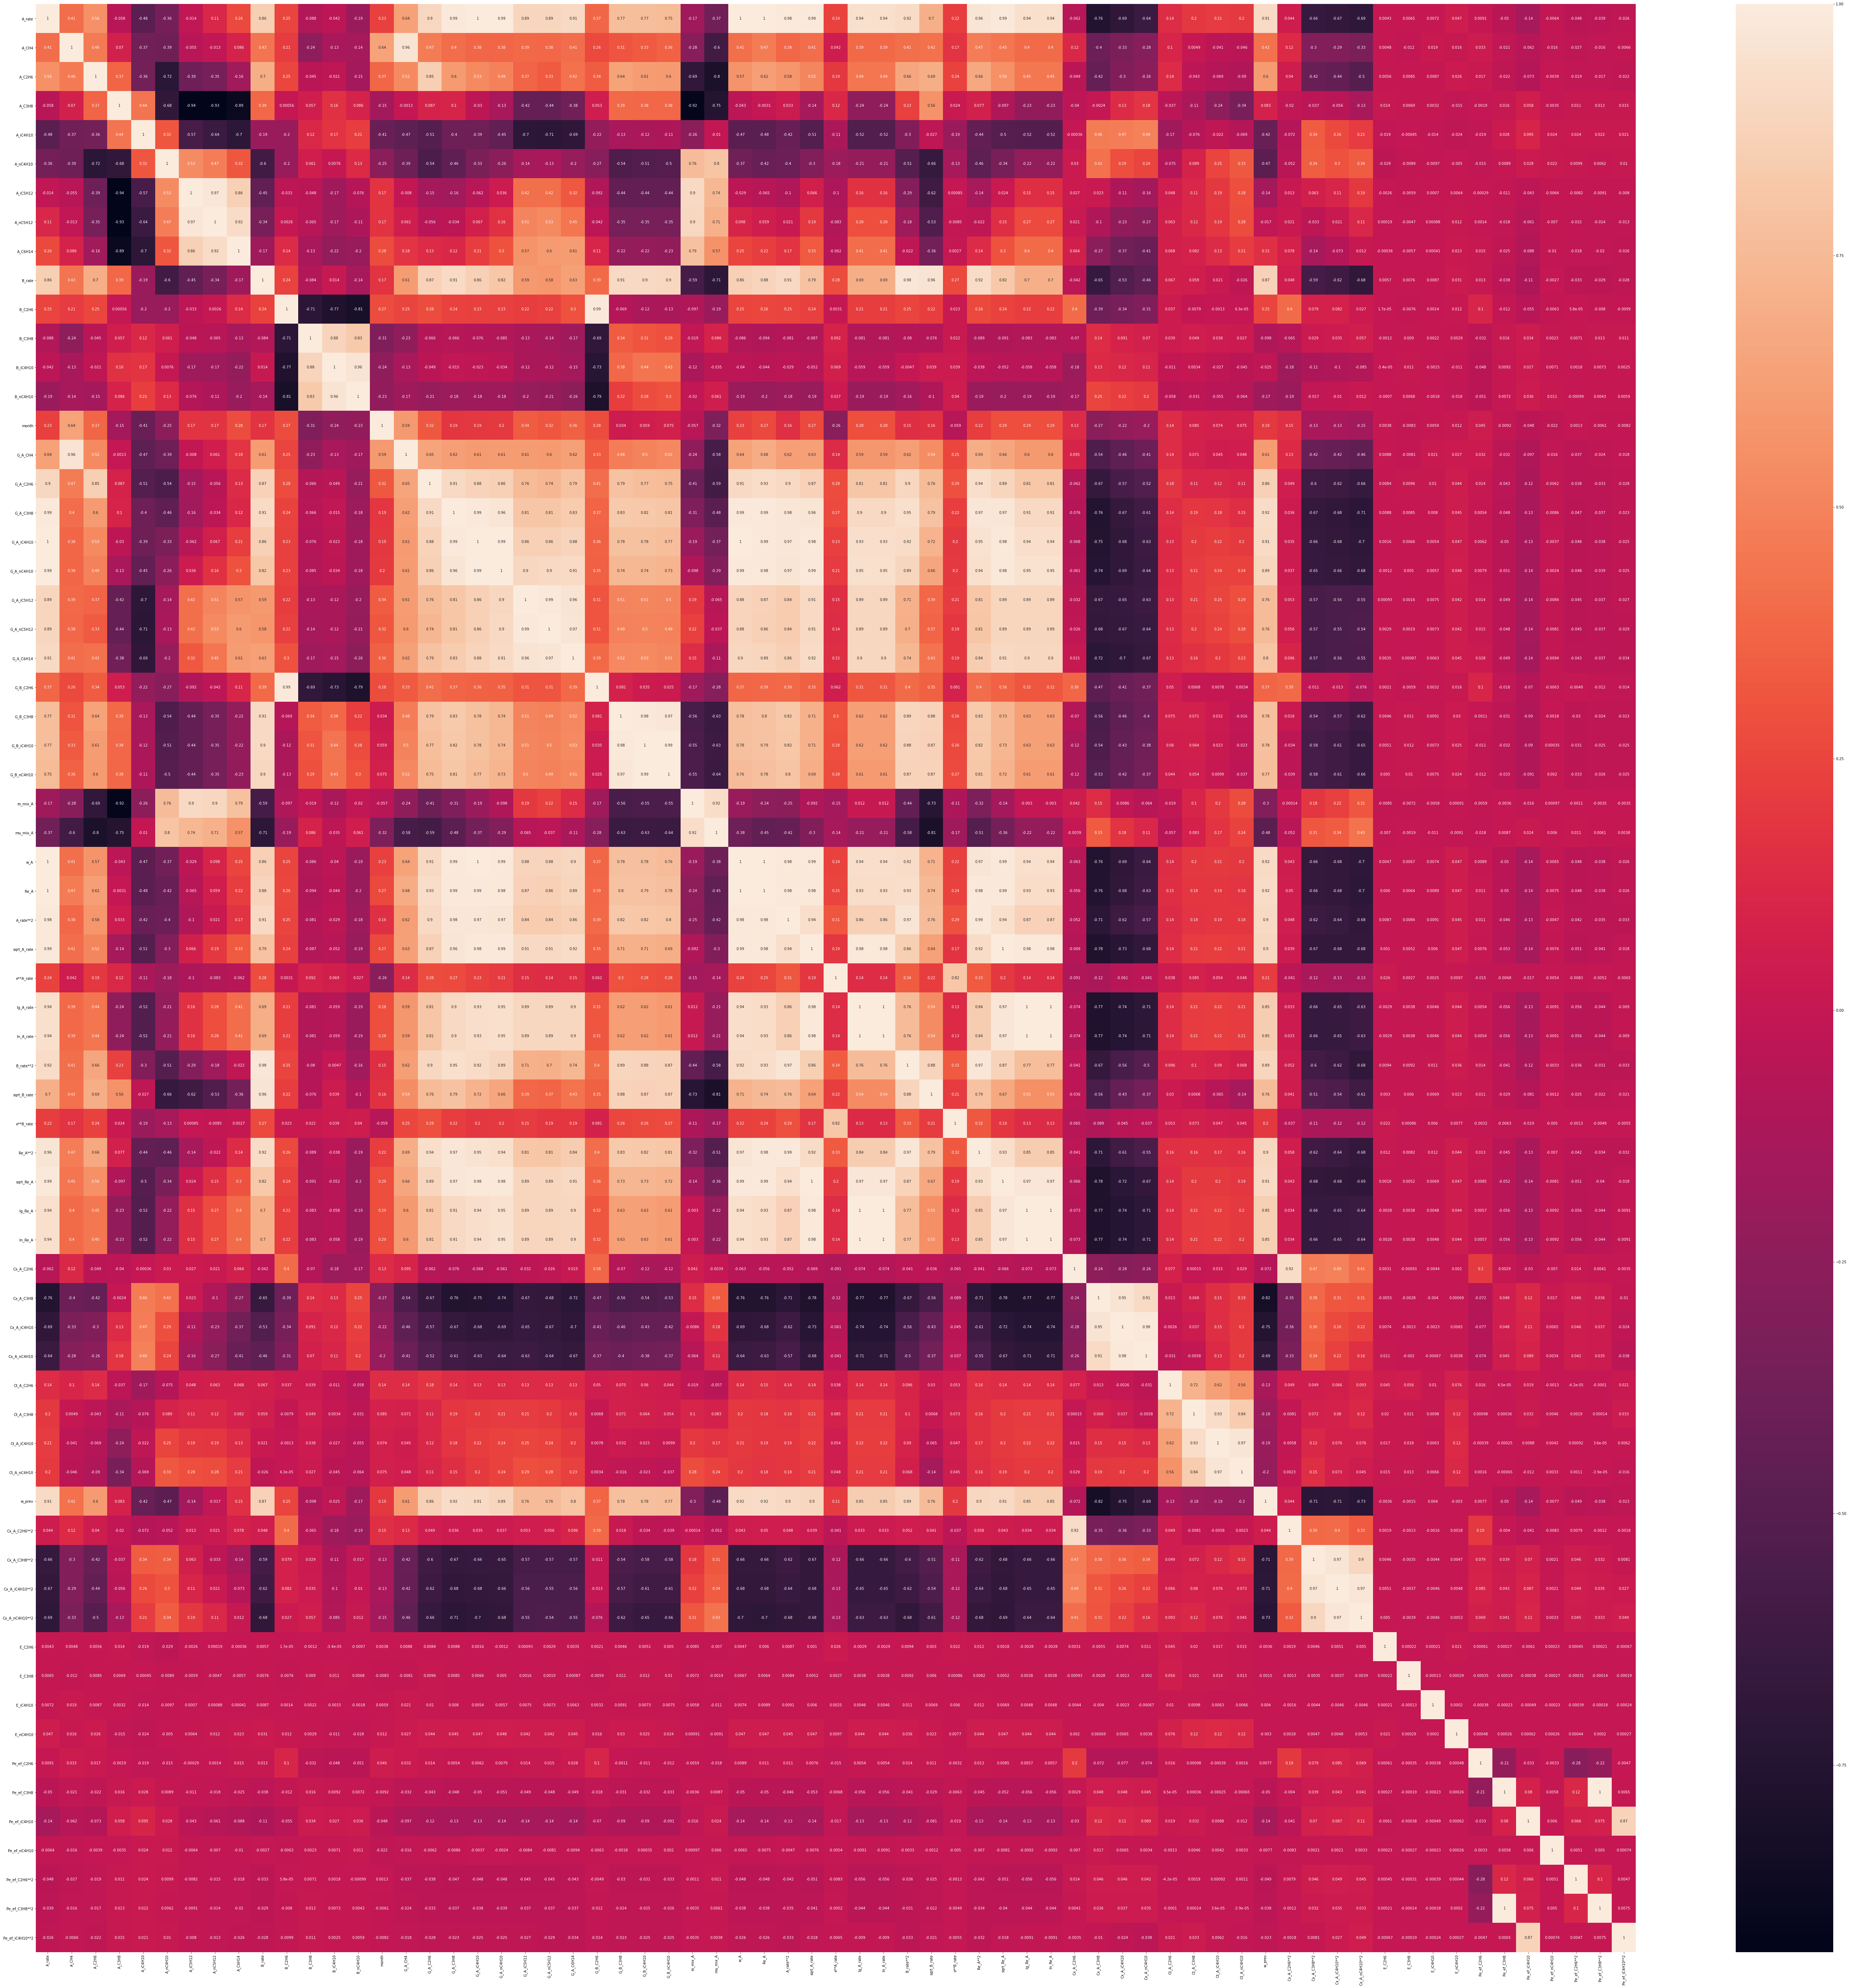

In [687]:
plt.figure(figsize=(100,100))
sns.heatmap(data.corr(), annot=True)

In [688]:
corrMatrix = pd.DataFrame()
corrMatrix['x'] = x.columns
corrMatrix['G_B_C2H6'] = np.array(x.corrwith(data['G_B_C2H6']))
corrMatrix['G_B_C3H8'] = np.array(x.corrwith(data['G_B_C3H8']))
corrMatrix['G_B_iC4H10'] = np.array(x.corrwith(data['G_B_iC4H10']))
corrMatrix['G_B_nC4H10'] = np.array(x.corrwith(data['G_B_nC4H10']))
corrMatrix['B_C2H6'] = np.array(x.corrwith(data['B_C2H6']))
corrMatrix['B_C3H8'] = np.array(x.corrwith(data['B_C3H8']))
corrMatrix['B_iC4H10'] = np.array(x.corrwith(data['B_iC4H10']))
corrMatrix['B_nC4H10'] = np.array(x.corrwith(data['B_nC4H10']))

In [689]:
corrMatrix

x  G_B_C2H6  G_B_C3H8  G_B_iC4H10  G_B_nC4H10    B_C2H6  \
0            A_rate  0.372574  0.771213    0.768611    0.753592  0.246307   
1             A_CH4  0.260119  0.310276    0.333062    0.362157  0.207733   
2            A_C2H6  0.341775  0.641420    0.611775    0.602359  0.251487   
3            A_C3H8  0.053060  0.389671    0.380262    0.380717  0.000561   
4          A_iC4H10 -0.223694 -0.133989   -0.121151   -0.109718 -0.198042   
5          A_nC4H10 -0.274150 -0.540383   -0.514151   -0.503420 -0.197982   
6          A_iC5H12 -0.091918 -0.443153   -0.440480   -0.437640 -0.032715   
7          A_nC5H12 -0.042201 -0.353333   -0.346571   -0.350619  0.002553   
8           A_C6H14  0.107466 -0.218986   -0.215106   -0.226416  0.135740   
9            B_rate  0.390181  0.908913    0.904265    0.900757  0.241711   
10            month  0.275853  0.033623    0.058967    0.074967  0.274549   
11          G_A_CH4  0.332748  0.477661    0.496517    0.517356  0.249605   
12         G_A_C2H6  0.405230  0.790206    0.767851    0.751817  0.281321   
13         G_A_C3H8  0.372166  0.832148    0.824468    0.807792  0.238289   
14       G_A_iC4H10  0.358406  0.783255    0.782503    0.767693  0.230904   
15       G_A_nC4H10  0.349880  0.736858    0.740229    0.727049  0.227917   
16       G_A_iC5H12  0.308707  0.505669    0.509232    0.502454  0.218741   
17       G_A_nC5H12  0.311602  0.490991    0.498474    0.488165  0.223288   
18        G_A_C6H14  0.389617  0.522337    0.528131    0.512510  0.299776   
19         ro_mix_A -0.174353 -0.563480   -0.548386   -0.549570 -0.096574   
20         mu_mix_A -0.280188 -0.633771   -0.627622   -0.637387 -0.187953   
21              w_A  0.374299  0.779211    0.775875    0.760770  0.247034   
22             Re_A  0.386610  0.795155    0.790776    0.777463  0.257233   
23        A_rate**2  0.388276  0.820427    0.815749    0.800681  0.249966   
24      sqrt_A_rate  0.349717  0.711561    0.709664    0.694645  0.235341   
25        e**A_rate  0.061795  0.298942    0.283926    0.278061  0.003094   
26        lg_A_rate  0.312143  0.620952    0.620053    0.605119  0.213965   
27        ln_A_rate  0.312143  0.620952    0.620053    0.605119  0.213965   
28        B_rate**2  0.395723  0.887376    0.882045    0.874139  0.246234   
29      sqrt_B_rate  0.354994  0.875714    0.870927    0.873276  0.215641   
30        e**B_rate  0.080721  0.257531    0.259998    0.274015  0.023381   
31          Re_A**2  0.403065  0.831422    0.823708    0.811049  0.263713   
32        sqrt_Re_A  0.360971  0.734823    0.732001    0.718027  0.243388   
33          lg_Re_A  0.315701  0.628993    0.627984    0.613271  0.216386   
34          ln_Re_A  0.315701  0.628993    0.627984    0.613271  0.216386   
35        Cx_A_C2H6  0.377477 -0.069686   -0.119359   -0.117543  0.397331   
36        Cx_A_C3H8 -0.470455 -0.557657   -0.538870   -0.527013 -0.387139   
37      Cx_A_iC4H10 -0.408624 -0.458253   -0.433825   -0.421889 -0.341891   
38      Cx_A_nC4H10 -0.373516 -0.404450   -0.380848   -0.366685 -0.314740   
39        Ct_A_C2H6  0.050498  0.075085    0.059948    0.043604  0.036599   
40        Ct_A_C3H8  0.006784  0.070610    0.064223    0.053641 -0.007856   
41      Ct_A_iC4H10  0.007807  0.031607    0.022613    0.009866 -0.001324   
42      Ct_A_nC4H10  0.003364 -0.015644   -0.022956   -0.036759  0.000063   
43           w_prev  0.371987  0.779729    0.779045    0.769475  0.247114   
44     Cx_A_C2H6**2  0.389312  0.017702   -0.033619   -0.039044  0.396230   
45     Cx_A_C3H8**2 -0.010913 -0.543790   -0.580124   -0.579129  0.078770   
46   Cx_A_iC4H10**2 -0.012744 -0.570470   -0.606038   -0.606391  0.082190   
47   Cx_A_nC4H10**2 -0.075578 -0.622577   -0.654655   -0.655743  0.026728   
48           E_C2H6  0.002100  0.004561    0.005142    0.005034  0.000017   
49           E_C3H8 -0.005867  0.011065    0.011791    0.010462 -0.007595   
50         E_iC4H10  0.003246  0.009133    0.007291    0.007520  0.001434   
51         E_n

In [690]:
for i in corrMatrix.drop(labels='x', axis=1).columns:
    print(i + ' = ' , sum(corrMatrix[i].apply(abs)))

G_B_C2H6 =  12.940683017197028
G_B_C3H8 =  25.046704993770316
G_B_iC4H10 =  25.018876282563884
G_B_nC4H10 =  24.758398691260524
B_C2H6 =  9.422893446059588
B_C3H8 =  4.369754105722396
B_iC4H10 =  4.02284174429307
B_nC4H10 =  7.151196834473697


In [691]:
corrMatrix[(corrMatrix['G_B_C2H6'] > 0.3) | (corrMatrix['G_B_C2H6'] < -0.3)][['x', 'G_B_C2H6']]

x  G_B_C2H6
0         A_rate  0.372574
2         A_C2H6  0.341775
9         B_rate  0.390181
11       G_A_CH4  0.332748
12      G_A_C2H6  0.405230
13      G_A_C3H8  0.372166
14    G_A_iC4H10  0.358406
15    G_A_nC4H10  0.349880
16    G_A_iC5H12  0.308707
17    G_A_nC5H12  0.311602
18     G_A_C6H14  0.389617
21           w_A  0.374299
22          Re_A  0.386610
23     A_rate**2  0.388276
24   sqrt_A_rate  0.349717
26     lg_A_rate  0.312143
27     ln_A_rate  0.312143
28     B_rate**2  0.395723
29   sqrt_B_rate  0.354994
31       Re_A**2  0.403065
32     sqrt_Re_A  0.360971
33       lg_Re_A  0.315701
34       ln_Re_A  0.315701
35     Cx_A_C2H6  0.377477
36     Cx_A_C3H8 -0.470455
37   Cx_A_iC4H10 -0.408624
38   Cx_A_nC4H10 -0.373516
43        w_prev  0.371987
44  Cx_A_C2H6**2  0.389312

In [692]:
d = data[['B_rate','G_A_CH4','G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10','G_A_iC5H12',
          'G_A_nC5H12','G_A_C6H14','Cx_A_C2H6','Cx_A_C3H8', 'Cx_A_iC4H10', 'Cx_A_nC4H10',
          'Re_A','Cx_A_C2H6**2','G_B_C2H6']]

In [693]:
data.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'timestamp', 'month', 'G_A_CH4', 'G_A_C2H6',
       'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12',
       'G_A_C6H14', 'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10',
       'ro_mix_A', 'mu_mix_A', 'w_A', 'Re_A', 'A_rate**2', 'sqrt_A_rate',
       'e**A_rate', 'lg_A_rate', 'ln_A_rate', 'B_rate**2', 'sqrt_B_rate',
       'e**B_rate', 'Re_A**2', 'sqrt_Re_A', 'lg_Re_A', 'ln_Re_A', 'Cx_A_C2H6',
       'Cx_A_C3H8', 'Cx_A_iC4H10', 'Cx_A_nC4H10', 'Ct_A_C2H6', 'Ct_A_C3H8',
       'Ct_A_iC4H10', 'Ct_A_nC4H10', 'w_prev', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
       'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10',
       'E_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C3H8', 'Pe_ef_iC4H10', 'Pe_ef_nC4H10',
       'Pe_ef_C2H6**2', 'Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],
      dtype='object')

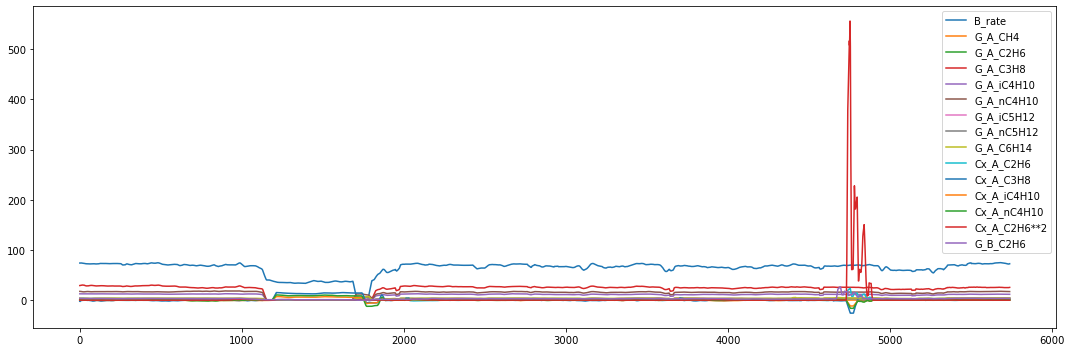

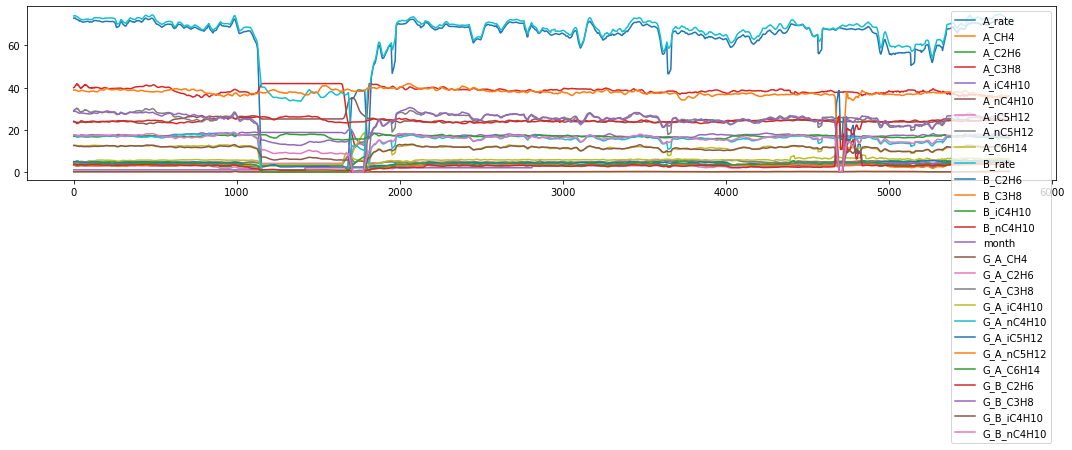

In [694]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [695]:
#запись DataFrame в файл
d.to_csv('train_data_C2H6.csv', sep=',', header=True, index=False)

In [696]:
corrMatrix[(corrMatrix['G_B_C3H8'] > 0.3) | (corrMatrix['G_B_C3H8'] < -0.3)][['x', 'G_B_C3H8']]

x  G_B_C3H8
0           A_rate  0.771213
1            A_CH4  0.310276
2           A_C2H6  0.641420
3           A_C3H8  0.389671
5         A_nC4H10 -0.540383
6         A_iC5H12 -0.443153
7         A_nC5H12 -0.353333
9           B_rate  0.908913
11         G_A_CH4  0.477661
12        G_A_C2H6  0.790206
13        G_A_C3H8  0.832148
14      G_A_iC4H10  0.783255
15      G_A_nC4H10  0.736858
16      G_A_iC5H12  0.505669
17      G_A_nC5H12  0.490991
18       G_A_C6H14  0.522337
19        ro_mix_A -0.563480
20        mu_mix_A -0.633771
21             w_A  0.779211
22            Re_A  0.795155
23       A_rate**2  0.820427
24     sqrt_A_rate  0.711561
26       lg_A_rate  0.620952
27       ln_A_rate  0.620952
28       B_rate**2  0.887376
29     sqrt_B_rate  0.875714
31         Re_A**2  0.831422
32       sqrt_Re_A  0.734823
33         lg_Re_A  0.628993
34         ln_Re_A  0.628993
36       Cx_A_C3H8 -0.557657
37     Cx_A_iC4H10 -0.458253
38     Cx_A_nC4H10 -0.404450
43          w_prev  0.779729
45    Cx_A_C3H8**2 -0.543790
46  Cx_A_iC4H10**2 -0.570470
47  Cx_A_nC4H10**2 -0.622577

In [697]:
d = data[['B_rate','G_A_CH4','G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10','G_A_iC5H12',
          'G_A_nC5H12','G_A_C6H14','Re_A','Cx_A_C3H8','Cx_A_nC4H10','Cx_A_iC4H10','Cx_A_C3H8**2',
          'Cx_A_iC4H10**2','Cx_A_nC4H10**2','G_B_C3H8']]

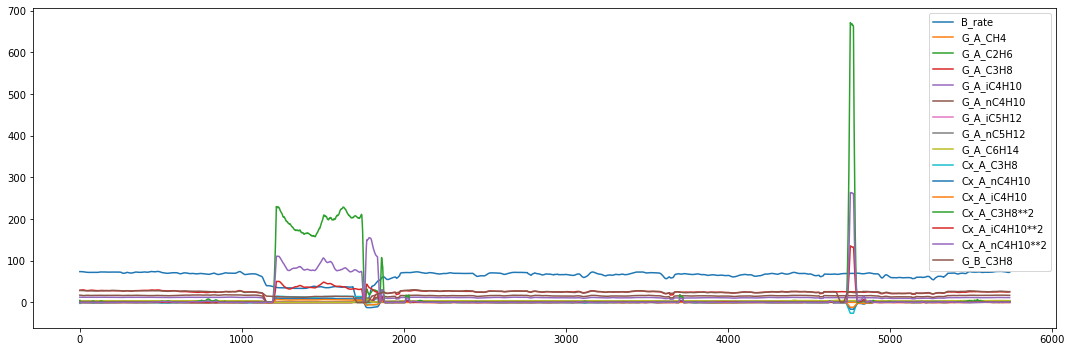

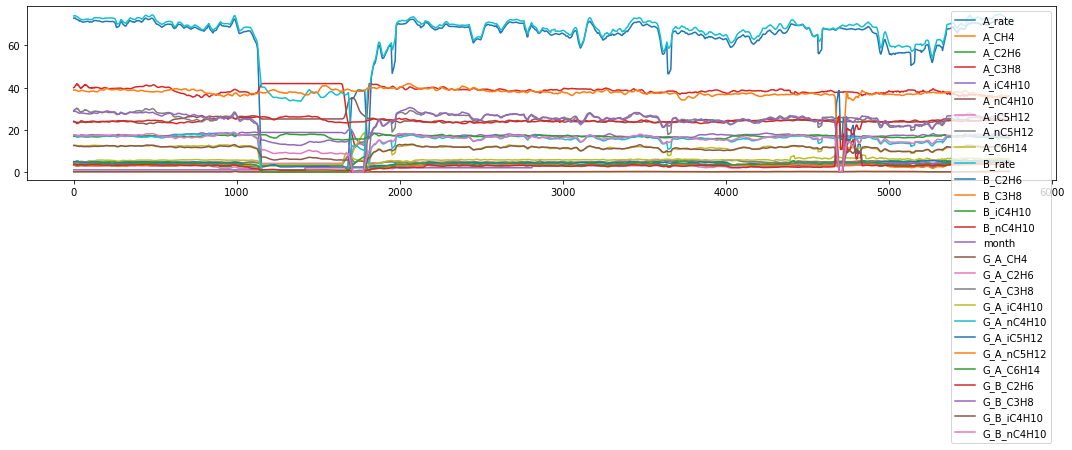

In [698]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [699]:
#запись DataFrame в файл
d.to_csv('train_data_C3H8.csv', sep=',', header=True, index=False)

In [700]:
corrMatrix[(corrMatrix['G_B_iC4H10'] > 0.3) | (corrMatrix['G_B_iC4H10'] < -0.3)][['x', 'G_B_iC4H10']]

x  G_B_iC4H10
0           A_rate    0.768611
1            A_CH4    0.333062
2           A_C2H6    0.611775
3           A_C3H8    0.380262
5         A_nC4H10   -0.514151
6         A_iC5H12   -0.440480
7         A_nC5H12   -0.346571
9           B_rate    0.904265
11         G_A_CH4    0.496517
12        G_A_C2H6    0.767851
13        G_A_C3H8    0.824468
14      G_A_iC4H10    0.782503
15      G_A_nC4H10    0.740229
16      G_A_iC5H12    0.509232
17      G_A_nC5H12    0.498474
18       G_A_C6H14    0.528131
19        ro_mix_A   -0.548386
20        mu_mix_A   -0.627622
21             w_A    0.775875
22            Re_A    0.790776
23       A_rate**2    0.815749
24     sqrt_A_rate    0.709664
26       lg_A_rate    0.620053
27       ln_A_rate    0.620053
28       B_rate**2    0.882045
29     sqrt_B_rate    0.870927
31         Re_A**2    0.823708
32       sqrt_Re_A    0.732001
33         lg_Re_A    0.627984
34         ln_Re_A    0.627984
36       Cx_A_C3H8   -0.538870
37     Cx_A_iC4H10   -0.433825
38     Cx_A_nC4H10   -0.380848
43          w_prev    0.779045
45    Cx_A_C3H8**2   -0.580124
46  Cx_A_iC4H10**2   -0.606038
47  Cx_A_nC4H10**2   -0.654655

In [701]:
d = data[['B_rate','G_A_CH4','G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10','G_A_iC5H12',
          'G_A_nC5H12','G_A_C6H14','Re_A','Cx_A_C3H8','Cx_A_nC4H10','Cx_A_iC4H10',
          'Cx_A_C3H8**2','Cx_A_iC4H10**2','Cx_A_nC4H10**2','G_B_iC4H10']]

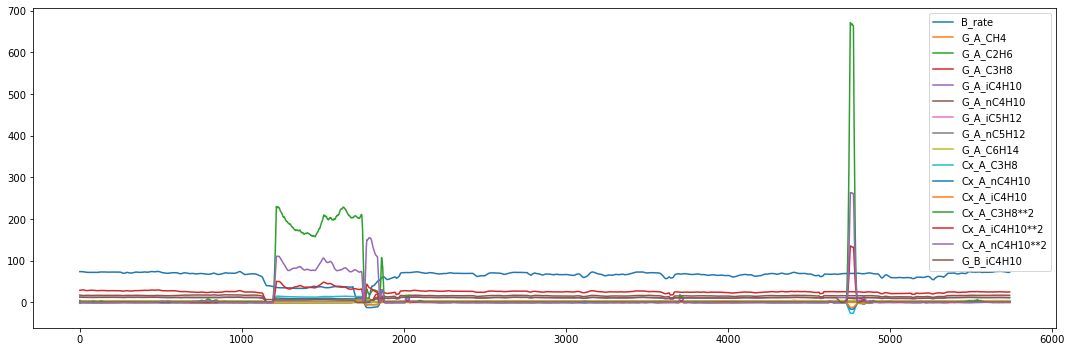

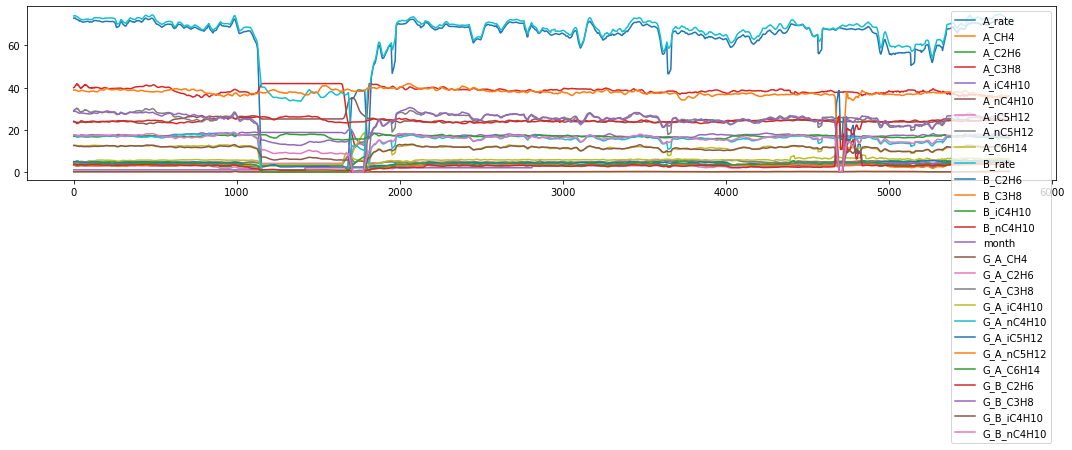

In [702]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [703]:
#запись DataFrame в файл
d.to_csv('train_data_iC4H10.csv', sep=',', header=True, index=False)

In [704]:
corrMatrix[(corrMatrix['G_B_nC4H10'] > 0.3) | (corrMatrix['G_B_nC4H10'] < -0.3)][['x','G_B_nC4H10']] 

x  G_B_nC4H10
0           A_rate    0.753592
1            A_CH4    0.362157
2           A_C2H6    0.602359
3           A_C3H8    0.380717
5         A_nC4H10   -0.503420
6         A_iC5H12   -0.437640
7         A_nC5H12   -0.350619
9           B_rate    0.900757
11         G_A_CH4    0.517356
12        G_A_C2H6    0.751817
13        G_A_C3H8    0.807792
14      G_A_iC4H10    0.767693
15      G_A_nC4H10    0.727049
16      G_A_iC5H12    0.502454
17      G_A_nC5H12    0.488165
18       G_A_C6H14    0.512510
19        ro_mix_A   -0.549570
20        mu_mix_A   -0.637387
21             w_A    0.760770
22            Re_A    0.777463
23       A_rate**2    0.800681
24     sqrt_A_rate    0.694645
26       lg_A_rate    0.605119
27       ln_A_rate    0.605119
28       B_rate**2    0.874139
29     sqrt_B_rate    0.873276
31         Re_A**2    0.811049
32       sqrt_Re_A    0.718027
33         lg_Re_A    0.613271
34         ln_Re_A    0.613271
36       Cx_A_C3H8   -0.527013
37     Cx_A_iC4H10   -0.421889
38     Cx_A_nC4H10   -0.366685
43          w_prev    0.769475
45    Cx_A_C3H8**2   -0.579129
46  Cx_A_iC4H10**2   -0.606391
47  Cx_A_nC4H10**2   -0.655743

In [705]:
d = data[['B_rate','G_A_CH4','G_A_C2H6','G_A_C3H8','G_A_iC4H10','G_A_nC4H10','G_A_iC5H12',
          'G_A_nC5H12','G_A_C6H14','Re_A','Cx_A_C3H8','Cx_A_iC4H10','Cx_A_nC4H10','Cx_A_C3H8**2',
          'Cx_A_iC4H10**2','Cx_A_nC4H10**2','G_B_nC4H10']]

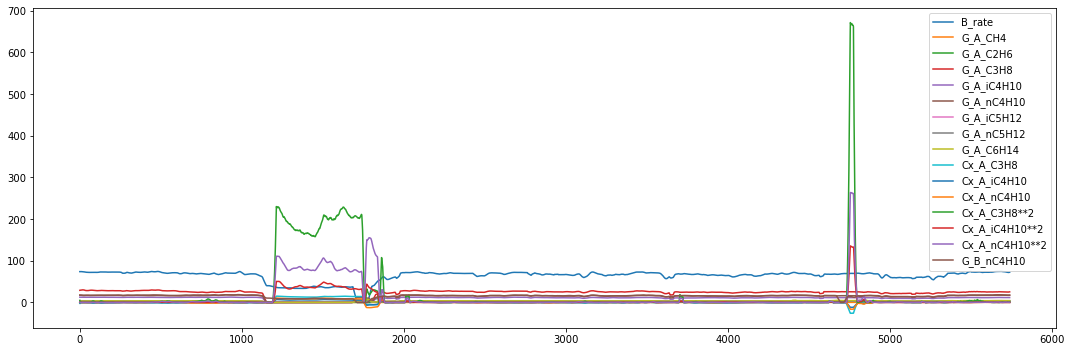

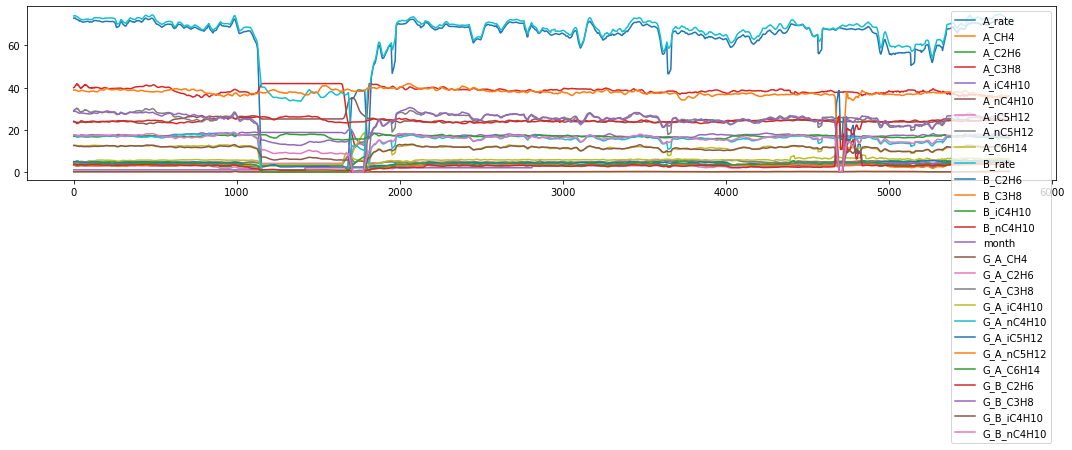

In [706]:
plt.rcParams["figure.figsize"] = (15,5)
d.drop("Re_A", axis=1)[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
data[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6', 'G_A_C3H8',
       'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12', 'G_A_C6H14',
       'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10']].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [707]:
#запись DataFrame в файл
d.to_csv('train_data_nC4H10.csv', sep=',', header=True, index=False)

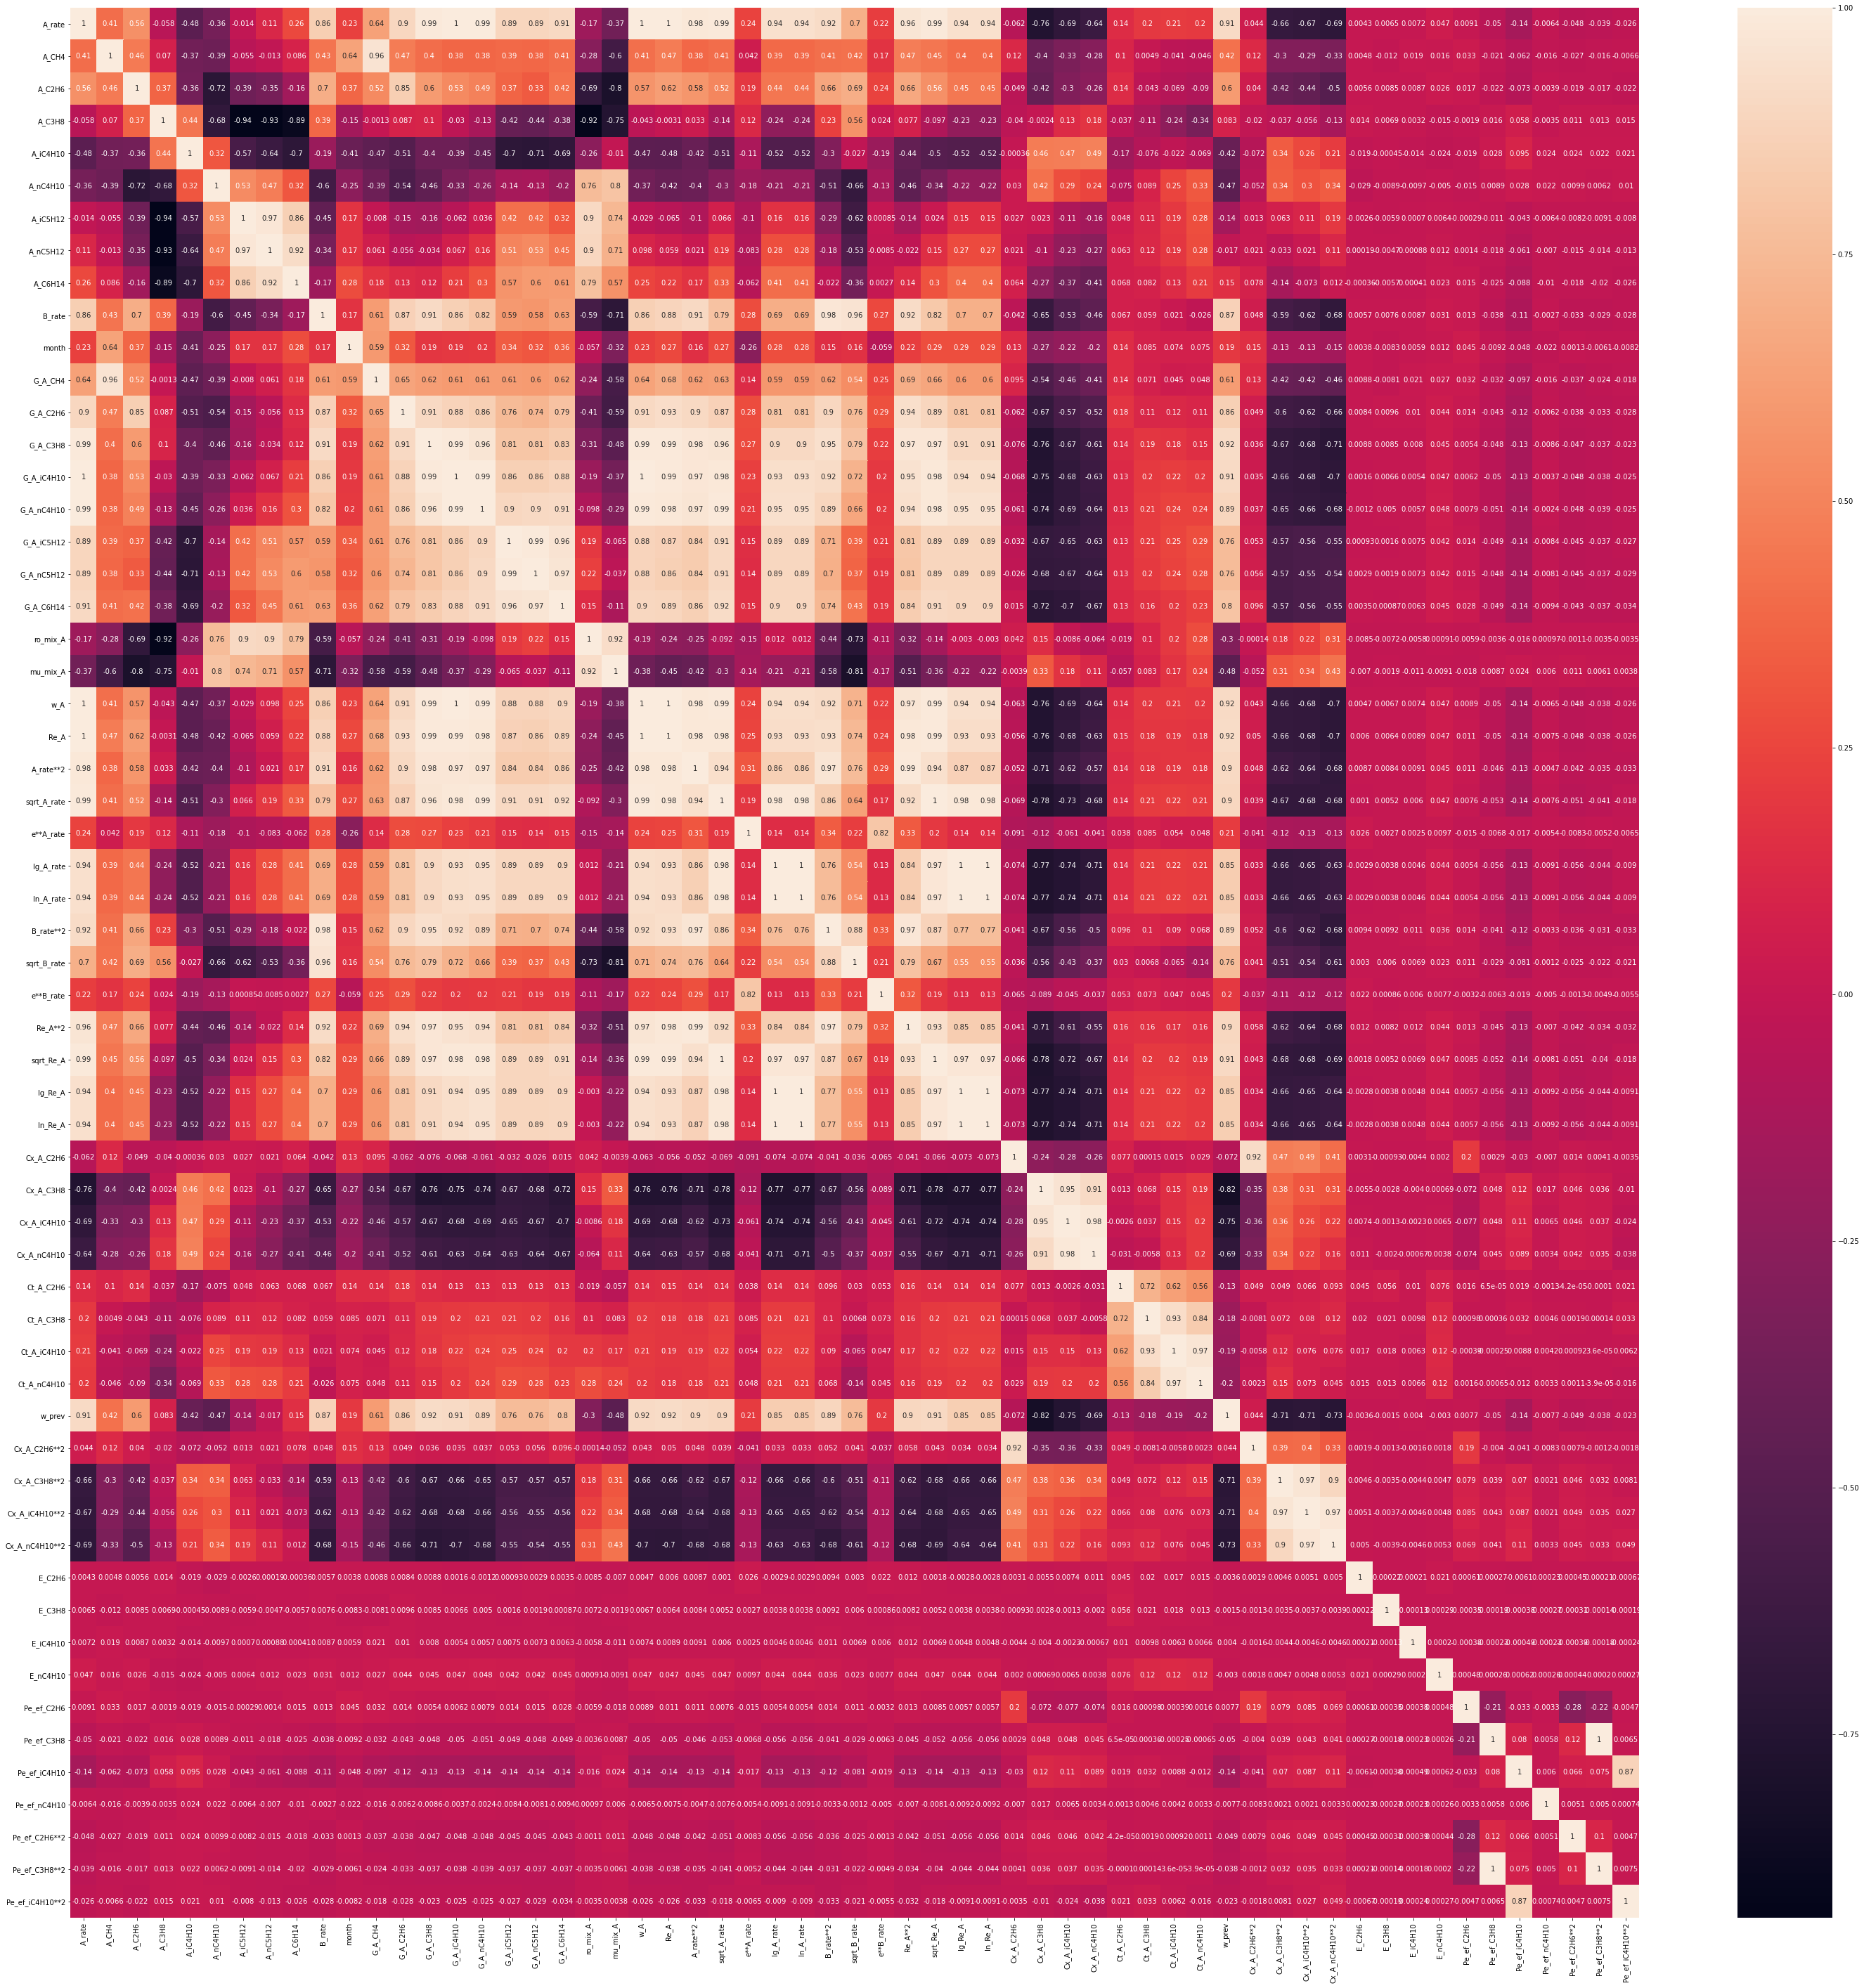

In [708]:
plt.figure(figsize=(50,50))
sns.heatmap(x.corr(), annot=True)

In [709]:
#запись DataFrame в файл
data.to_csv('train_data.csv', sep=',', header=True, index=False)

1. ГОСТ 28656-90
2. "Природные и искусственные газы. Учебник для техникумов. 4-е изд. 1978 г" Рябцев Н.И.
3. Wikipedia

In [710]:
#!cat train_data.csv

## Обработаем test_features

In [711]:
monthList =[]
for i in test_features['timestamp']:
    monthList.append(int(str(i)[5:7]))

In [712]:
test_features['month'] = monthList

In [713]:
test_features = test_features.ffill(axis = 0)
test_features.isnull().sum()

timestamp    0
A_rate       0
A_CH4        0
A_C2H6       0
A_C3H8       0
A_iC4H10     0
A_nC4H10     0
A_iC5H12     0
A_nC5H12     0
A_C6H14      0
B_rate       0
month        0
dtype: int64

In [714]:
test_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-05-01 00:00:00  71.428342  0.267832  5.135159  36.816480   
1     2020-05-01 00:30:00  70.925118  0.268464  5.149646  36.869023   
2     2020-05-01 01:00:00  70.991719  0.270641  5.154615  37.074965   
3     2020-05-01 01:30:00  70.972406  0.275241  5.230661  37.384180   
4     2020-05-01 02:00:00  70.980078  0.275062  5.241437  37.448587   
...                   ...        ...       ...       ...        ...   
3979  2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930   
3980  2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418   
3981  2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323   
3982  2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503   
3983  2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  month  
0     16.632260  24.062587  5.696004  4.939430  6.395286  74.273009      5  
1     16.651870  24.069800  5.676384  4.911872  6.346957  74.061833      5  
2     16.710967  24.106152  5.574873  4.808516  6.242636  73.856268      5  
3     16.683337  24.021993  5.514843  4.730887  6.101647  73.750744      5  
4     16.663863  24.003237  5.524898  4.728882  6.057119  73.698447      5  
...         ...        ...       ...       ...       ...        ...    ...  
3979  17.741460  24.098520  4.469224  3.619095  4.686205  75.486026      7  
3980  17.449352  24.049532  4.770699  3.988215  6.689777  75.370451      7  
3981  17.635380  24.169473  4.613603  3.790651  5.785216  74.985878      7  
3982  17.758833  24.211013  4.504242  3.657459  5.094626  74.766867      7  
3983  17.772225  24.088445  4.387957  3.536302  4.863965  74.804667      7  

[3984 rows x 12 columns]

In [715]:
test_features_prev = test_features
test_features = test_features.rolling(25, min_periods=0).mean()

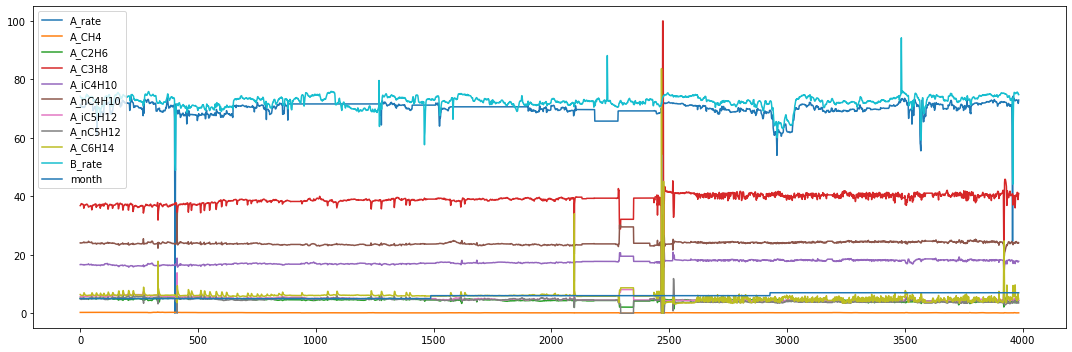

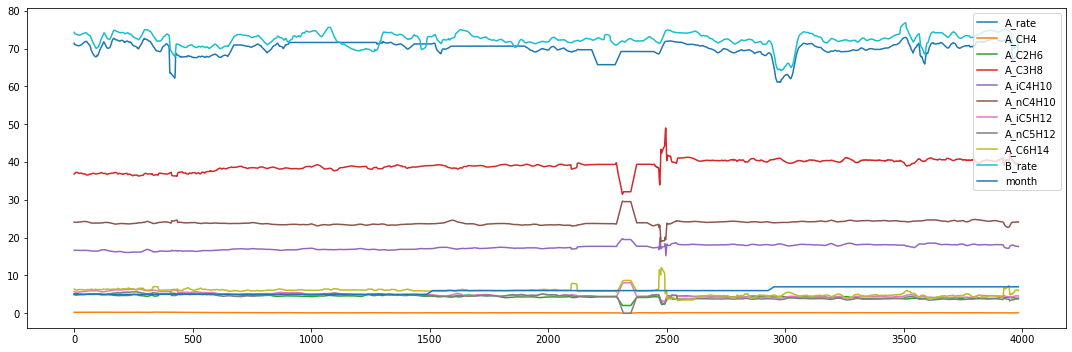

In [716]:
plt.rcParams["figure.figsize"] = (15,5)
test_features_prev[:].plot()
# make room for tick labels
plt.tight_layout()

plt.rcParams["figure.figsize"] = (15,5)
test_features[:].plot()
# make room for tick labels
plt.tight_layout()

plt.show()

In [717]:
test_features['timestamp'] = test_features_prev['timestamp']

In [718]:
test_features['G_A_CH4'] = test_features['A_rate'] * test_features['A_CH4'] / 100
test_features['G_A_C2H6'] = test_features['A_rate'] * test_features['A_C2H6'] / 100
test_features['G_A_C3H8'] = test_features['A_rate'] * test_features['A_C3H8'] / 100
test_features['G_A_iC4H10'] = test_features['A_rate'] * test_features['A_iC4H10'] / 100
test_features['G_A_nC4H10'] = test_features['A_rate'] * test_features['A_nC4H10'] / 100
test_features['G_A_iC5H12'] = test_features['A_rate'] * test_features['A_iC5H12'] / 100
test_features['G_A_nC5H12'] = test_features['A_rate'] * test_features['A_nC5H12'] / 100
test_features['G_A_C6H14'] = test_features['A_rate'] * test_features['A_C6H14'] / 100

In [719]:
test_features['ro_mix_A'] = ((test_features['A_CH4'] / 100 / ro_CH4) + (test_features['A_C2H6'] / 100 / ro_C2H6) 
                  + (test_features['A_C3H8'] / 100 / ro_C3H8) + (test_features['A_iC4H10'] / 100 / ro_iC4H10) 
                  + (test_features['A_nC4H10'] / 100 / ro_nC4H10) + (test_features['A_iC5H12'] / 100 / ro_iC5H12)
                  + (test_features['A_nC5H12'] / 100 / ro_nC5H12) + (test_features['A_C6H14'] / 100 / ro_C6H14))**-1

In [720]:
test_features['mu_mix_A'] = (((test_features['A_CH4'] / 100) * (test_features['ro_mix_A'] / ro_CH4)) / mu_CH4 
                  + ((test_features['A_C2H6'] / 100) * (test_features['ro_mix_A'] / ro_C2H6)) / mu_C2H6 
                  + ((test_features['A_C3H8'] / 100) * (test_features['ro_mix_A'] / ro_C3H8)) / mu_C3H8
                  + ((test_features['A_iC4H10'] / 100) * (test_features['ro_mix_A'] / ro_iC4H10)) / mu_iC4H10
                  + ((test_features['A_nC4H10'] / 100) * (test_features['ro_mix_A'] / ro_nC4H10)) / mu_nC4H10
                  + ((test_features['A_iC5H12'] / 100) * (test_features['ro_mix_A'] / ro_iC5H12)) / mu_iC5H12
                  + ((test_features['A_nC5H12'] / 100) * (test_features['ro_mix_A'] / ro_nC5H12)) / mu_nC5H12
                  + ((test_features['A_C6H14'] / 100) * (test_features['ro_mix_A'] / ro_C6H14)) / mu_C6H14)**-1

In [721]:
test_features['w_A'] = (4*test_features['A_rate']*0.278)/(3.14*test_features['ro_mix_A']*0.16)
test_features['Re_A'] = (4*test_features['A_rate']*0.278)/(3.14*0.4*test_features['mu_mix_A'])

In [722]:
test_features['A_rate**2'] = test_features['A_rate']**2
test_features['sqrt_A_rate'] = test_features['A_rate'].apply(m.sqrt)
test_features['e**A_rate'] = test_features['A_rate'].apply(m.exp)
test_features['lg_A_rate'] = test_features['A_rate'].apply(m.log10)
test_features['ln_A_rate'] = test_features['A_rate'].apply(m.log)

test_features['B_rate**2'] = test_features['B_rate']**2
test_features['sqrt_B_rate'] = test_features['B_rate'].apply(m.sqrt)
test_features['e**B_rate'] = test_features['B_rate'].apply(m.exp)


test_features['Re_A**2'] = test_features['Re_A']**2
test_features['sqrt_Re_A'] = test_features['Re_A'].apply(m.sqrt)

test_features['lg_Re_A'] = test_features['Re_A'].apply(m.log10)
test_features['ln_Re_A'] = test_features['Re_A'].apply(m.log)

In [723]:
test_features

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     71.428342  0.267832  5.135159  36.816480  16.632260  24.062587   
1     71.176730  0.268148  5.142402  36.842752  16.642065  24.066193   
2     71.115060  0.268979  5.146473  36.920156  16.665032  24.079513   
3     71.079396  0.270545  5.167520  37.036162  16.669608  24.065133   
4     71.059532  0.271448  5.182303  37.118647  16.668459  24.052754   
...         ...       ...       ...        ...        ...        ...   
3979  68.304891  0.119512  4.025974  39.598743  17.690124  24.125104   
3980  68.632519  0.119121  4.015950  39.536427  17.662900  24.111860   
3981  69.834182  0.118976  4.002939  39.496366  17.645730  24.110723   
3982  71.735081  0.119308  3.991399  39.479565  17.635418  24.113394   
3983  72.741092  0.120283  3.998443  39.627151  17.650079  24.115738   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate  month            timestamp  \
0     5.696004  4.939430  6.395286  74.273009    5.0  2020-05-01 00:00:00   
1     5.686194  4.925651  6.371121  74.167421    5.0  2020-05-01 00:30:00   
2     5.649087  4.886606  6.328293  74.063703    5.0  2020-05-01 01:00:00   
3     5.615526  4.847676  6.271631  73.985463    5.0  2020-05-01 01:30:00   
4     5.597400  4.823918  6.228729  73.928060    5.0  2020-05-01 02:00:00   
...        ...       ...       ...        ...    ...                  ...   
3979  4.584583  3.754411  6.050439  71.147451    7.0  2020-07-22 21:30:00   
3980  4.598629  3.773469  6.130404  71.256112    7.0  2020-07-22 22:00:00   
3981  4.610501  3.788795  6.174530  71.607384    7.0  2020-07-22 22:30:00   
3982  4.617921  3.798771  6.192439  72.582642    7.0  2020-07-22 23:00:00   
3983  4.596188  3.772929  6.066762  73.808644    7.0  2020-07-22 23:30:00   

       G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  \
0     0.191308  3.667959  26.297401   11.880148   17.187507    4.068561   
1     0.190859  3.660194  26.223466   11.845278   17.129529    4.047247   
2     0.191285  3.659918  26.255791   11.851348   17.124160    4.017352   
3     0.192301  3.673042  26.325080   11.848657   17.105351    3.991482   
4     0.192890  3.682521  26.376337   11.844529   17.091774    3.977487   
...        ...       ...        ...         ...         ...         ...   
3979  0.081633  2.749937  27.047878   12.083220   16.478626    3.131494   
3980  0.081756  2.756247  27.134846   12.122493   16.548577    3.156155   
3981  0.083086  2.795420  27.581964   12.322751   16.837526    3.219705   
3982  0.085586  2.863233  28.320698   12.650781   17.297763    3.312669   
3983  0.087495  2.908511  28.825223   12.838860   17.542051    3.343317   

      G_A_nC5H12  G_A_C6H14    ro_mix_A  mu_mix_A       w_A           Re_A  \
0       3.528153   4.568047  562.574167  0.000151  0.281026  419019.690291   
1       3.505918   4.534756  562.513894  0.000151  0.280066  417716.031332   
2       3.475113   4.500369  562.390951  0.000151  0.279884  417677.086653   
3       3.445699   4.457838  562.189616  0.000151  0.279844  418092.480177   
4       3.427853   4.426106  562.050079  0.000150  0.279835  418391.849005   
...          ...        ...         ...       ...       ...            ...   
3979    2.564446   4.132746  563.020705  0.000159  0.268524  380844.777764   
3980    2.589827   4.207451  563.157117  0.000159  0.269746  382368.259444   
3981    2.645874   4.311932  563.259337  0.000159  0.274419  388821.338979   
3982    2.725052   4.442151  563.319351  0.000159  0.281859  399288.163412   
3983    2.744470   4.413029  563.101145  0.000159  0.285923  405435.375734   

        A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate  \
0     5102.008078     8.451529  1.049385e+31   1.853871   4.268695   
1     5066.126880     8.436630  8.159453e+30   1.852338   4.265166   
2     5057.351702     8.432975  7.671459e+30   1.851962   4.264299   
3     5052.280554     8.430860  7.402689e+30   1.851744   4.263798   
4     5049.457156     8.429682 

In [724]:
last_line

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
5679  72.226067  0.289523  5.069140  35.472953  16.644436  24.555772   
5680  72.237165  0.293365  5.077082  35.410744  16.629716  24.559571   
5681  72.224809  0.297551  5.089825  35.379382  16.619932  24.563085   
5682  72.204582  0.301700  5.101183  35.332989  16.609731  24.570546   
5683  72.114710  0.305760  5.111913  35.277796  16.599591  24.579755   
5684  72.063714  0.310236  5.129893  35.251586  16.590110  24.580209   
5685  72.055175  0.315794  5.165219  35.297443  16.574923  24.553661   
5686  72.035381  0.321902  5.210758  35.403457  16.554520  24.501575   
5687  71.984491  0.327362  5.248261  35.501916  16.548473  24.466048   
5688  71.908691  0.331866  5.274162  35.539484  16.559280  24.476264   
5689  71.823419  0.335984  5.294705  35.534566  16.568072  24.497731   
5690  71.749980  0.340107  5.314277  35.517171  16.571746  24.512660   
5691  71.682885  0.344120  5.329931  35.492148  16.577482  24.528236   
5692  71.615374  0.348295  5.344560  35.465075  16.580710  24.539998   
5693  71.550940  0.352570  5.358580  35.437665  16.582366  24.549432   
5694  71.487309  0.356857  5.372114  35.410300  16.583626  24.557571   
5695  71.423004  0.361122  5.385451  35.381410  16.583972  24.563958   
5696  71.366321  0.365358  5.398666  35.348019  16.584525  24.570615   
5697  71.318953  0.369716  5.412902  35.314133  16.584677  24.576265   
5698  71.296418  0.374138  5.425696  35.282283  16.583993  24.580146   
5699  71.275221  0.378246  5.433325  35.255148  16.582510  24.582887   
5700  71.260929  0.381381  5.437440  35.234502  16.581197  24.584505   
5701  71.237726  0.383002  5.439637  35.224093  16.580493  24.584677   
5702  71.220976  0.383002  5.439637  35.224093  16.580493  24.584677   
5703  71.221180  0.383002  5.439637  35.224093  16.580493  24.584677   
5704  71.198450  0.383002  5.439637  35.224093  16.580493  24.584677   
5705  71.178174  0.383002  5.439637  35.224093  16.580493  24.584677   
5706  71.158651  0.383002  5.439637  35.224093  16.580493  24.584677   
5707  71.133669  0.383002  5.439637  35.224093  16.580493  24.584677   
5708  71.132673  0.383002  5.439637  35.224093  16.580493  24.584677   
5709  71.107903  0.383002  5.439637  35.224093  16.580493  24.584677   
5710  70.992734  0.383002  5.439637  35.224093  16.580493  24.584677   
5711  70.889338  0.380295  5.428504  35.252426  16.585992  24.586178   
5712  70.788378  0.377653  5.418330  35.281293  16.591401  24.586770   
5713  70.694283  0.375254  5.412385  35.314966  16.597399  24.585112   
5714  70.638274  0.372835  5.406076  35.348958  16.603188  24.582586   
5715  70.594942  0.370371  5.398970  35.383579  16.609356  24.580612   
5716  70.539932  0.367924  5.391205  35.421998  16.615052  24.577407   
5717  70.478452  0.365401  5.380530  35.464622  16.621613  24.574950   
5718  70.420168  0.362852  5.368007  35.510825  16.628918  24.572973   
5719  70.361209  0.360261  5.354179  35.554397  16.636045  24.570922   
5720  70.298427  0.357346  5.335768  35.567729  16.641175  24.574295   
5721  70.224322  0.354131  5.313802  35.550041  16.640611  24.576203   
5722  70.139632  0.351034  5.293923  35.542715  16.638450  24.569626   
5723  70.020211  0.348059  5.276879  35.554598  16.639345  24.562183   
5724  69.938496  0.344957  5.260547  35.579109  16.643636  24.556664   
5725  69.872123  0.342030  5.246403  35.614189  16.648769  24.550087   
5726  69.819413  0.339003  5.232173  35.652667  16.654720  24.545880   
5727  69.737543  0.335794  5.215399  35.693109  16.658213  24.541174   
5728  69.670540  0.332689  5.197979  35.741118  16.659655  24.533590   
5729  69.676093  0.329495  5.181632  35.795160  16.661287  24.524450   
5730  69.701145  0.326294  5.166590  35.853990  16.662476  24.512971   
5731  69.763842  0.322950  5.152236  35.915220  16.663066  24.500222   
5732  69.839262  0.319492  5.138202  35.979001  16.662163  24.485411   
5733  69.928553  0.315853  5.122735  36.037755  1

In [725]:
test_features = pd.concat([last_line,test_features], axis=0)
test_features = test_features.reset_index(drop=True)

In [726]:
test_features

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     72.226067  0.289523  5.069140  35.472953  16.644436  24.555772   
1     72.237165  0.293365  5.077082  35.410744  16.629716  24.559571   
2     72.224809  0.297551  5.089825  35.379382  16.619932  24.563085   
3     72.204582  0.301700  5.101183  35.332989  16.609731  24.570546   
4     72.114710  0.305760  5.111913  35.277796  16.599591  24.579755   
...         ...       ...       ...        ...        ...        ...   
4039  68.304891  0.119512  4.025974  39.598743  17.690124  24.125104   
4040  68.632519  0.119121  4.015950  39.536427  17.662900  24.111860   
4041  69.834182  0.118976  4.002939  39.496366  17.645730  24.110723   
4042  71.735081  0.119308  3.991399  39.479565  17.635418  24.113394   
4043  72.741092  0.120283  3.998443  39.627151  17.650079  24.115738   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8   B_iC4H10  \
0     6.031120  5.413186  6.470315  74.851774  4.977989  35.993070  16.417060   
1     6.046349  5.436488  6.492651  74.859300  4.999293  36.060937  16.415238   
2     6.050410  5.446538  6.498729  74.848533  5.020295  36.098497  16.412917   
3     6.059452  5.462830  6.506519  74.817863  5.044432  36.144059  16.418947   
4     6.070154  5.481432  6.518063  74.776490  5.072765  36.233689  16.442558   
...        ...       ...       ...        ...       ...        ...        ...   
4039  4.584583  3.754411  6.050439  71.147451       NaN        NaN        NaN   
4040  4.598629  3.773469  6.130404  71.256112       NaN        NaN        NaN   
4041  4.610501  3.788795  6.174530  71.607384       NaN        NaN        NaN   
4042  4.617921  3.798771  6.192439  72.582642       NaN        NaN        NaN   
4043  4.596188  3.772929  6.066762  73.808644       NaN        NaN        NaN   

       B_nC4H10            timestamp  month   G_A_CH4  G_A_C2H6   G_A_C3H8  \
0     24.605813  2020-04-29 18:00:00    4.0  0.209111  3.661240  25.620719   
1     24.586777  2020-04-29 18:30:00    4.0  0.211919  3.667540  25.579718   
2     24.573314  2020-04-29 19:00:00    4.0  0.214905  3.676116  25.552691   
3     24.571099  2020-04-29 19:30:00    4.0  0.217841  3.683288  25.512037   
4     24.594553  2020-04-29 20:00:00    4.0  0.220498  3.686442  25.440480   
...         ...                  ...    ...       ...       ...        ...   
4039        NaN  2020-07-22 21:30:00    7.0  0.081633  2.749937  27.047878   
4040        NaN  2020-07-22 22:00:00    7.0  0.081756  2.756247  27.134846   
4041        NaN  2020-07-22 22:30:00    7.0  0.083086  2.795420  27.581964   
4042        NaN  2020-07-22 23:00:00    7.0  0.085586  2.863233  28.320698   
4043        NaN  2020-07-22 23:30:00    7.0  0.087495  2.908511  28.825223   

      G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6  \
0      12.021622   17.735668    4.356041    3.909731   4.673254  3.726113   
1      12.012836   17.741138    4.367711    3.927165   4.690107  3.742436   
2      12.003714   17.740641    4.369897    3.933751   4.693695  3.757617   
3      11.992987   17.741060    4.375202    3.944413   4.698005  3.774136   
4      11.970747   17.725619    4.377474    3.952918   4.700482  3.793235   
...          ...         ...         ...         ...        ...       ...   
4039   12.083220   16.478626    3.131494    2.564446   4.132746       NaN   
4040   12.122493   16.548577    3.156155    2.589827   4.207451       NaN   
4041   12.322751   16.837526    3.219705    2.645874   4.311932       NaN   
4042   12.650781   17.297763    3.312669    2.725052   4.442151       NaN   
4043   12.838860   17.542051    3.343317    2.744470   4.413029       NaN   

       G_B_C3H8  G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A  \
0     26.941451   12.288461   18.417888  563.895812  0.000151  0.283498   
1     26.994965   12.288333   18.405489  563.931163  0.000151  0.283524   
2     27.019196   12.284828   18.392765  563.911676  0.000151  0.283485   
3     27.

In [727]:
test_features.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6', 'B_C3H8',
       'B_iC4H10', 'B_nC4H10', 'timestamp', 'month', 'G_A_CH4', 'G_A_C2H6',
       'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12',
       'G_A_C6H14', 'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10',
       'ro_mix_A', 'mu_mix_A', 'w_A', 'Re_A', 'A_rate**2', 'sqrt_A_rate',
       'e**A_rate', 'lg_A_rate', 'ln_A_rate', 'B_rate**2', 'sqrt_B_rate',
       'e**B_rate', 'Re_A**2', 'sqrt_Re_A', 'lg_Re_A', 'ln_Re_A', 'Cx_A_C2H6',
       'Cx_A_C3H8', 'Cx_A_iC4H10', 'Cx_A_nC4H10', 'Ct_A_C2H6', 'Ct_A_C3H8',
       'Ct_A_iC4H10', 'Ct_A_nC4H10', 'w_prev', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
       'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10',
       'E_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C3H8', 'Pe_ef_iC4H10', 'Pe_ef_nC4H10',
       'Pe_ef_C2H6**2', 'Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],
      dtype='object')

In [728]:
test_features = test_features.drop(labels=['B_C2H6','B_C3H8', 'B_iC4H10', 'B_nC4H10','E_C2H6', 'E_C3H8',
                                           'E_iC4H10','E_nC4H10', 'Pe_ef_iC4H10','Ct_A_C2H6', 'Ct_A_C3H8',
                                           'Ct_A_iC4H10', 'Ct_A_nC4H10','Pe_ef_nC4H10','Pe_ef_C2H6**2',
                                           'Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],axis=1)

In [729]:
test_features

A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10   A_nC4H10  \
0     72.226067  0.289523  5.069140  35.472953  16.644436  24.555772   
1     72.237165  0.293365  5.077082  35.410744  16.629716  24.559571   
2     72.224809  0.297551  5.089825  35.379382  16.619932  24.563085   
3     72.204582  0.301700  5.101183  35.332989  16.609731  24.570546   
4     72.114710  0.305760  5.111913  35.277796  16.599591  24.579755   
...         ...       ...       ...        ...        ...        ...   
4039  68.304891  0.119512  4.025974  39.598743  17.690124  24.125104   
4040  68.632519  0.119121  4.015950  39.536427  17.662900  24.111860   
4041  69.834182  0.118976  4.002939  39.496366  17.645730  24.110723   
4042  71.735081  0.119308  3.991399  39.479565  17.635418  24.113394   
4043  72.741092  0.120283  3.998443  39.627151  17.650079  24.115738   

      A_iC5H12  A_nC5H12   A_C6H14     B_rate            timestamp  month  \
0     6.031120  5.413186  6.470315  74.851774  2020-04-29 18:00:00    4.0   
1     6.046349  5.436488  6.492651  74.859300  2020-04-29 18:30:00    4.0   
2     6.050410  5.446538  6.498729  74.848533  2020-04-29 19:00:00    4.0   
3     6.059452  5.462830  6.506519  74.817863  2020-04-29 19:30:00    4.0   
4     6.070154  5.481432  6.518063  74.776490  2020-04-29 20:00:00    4.0   
...        ...       ...       ...        ...                  ...    ...   
4039  4.584583  3.754411  6.050439  71.147451  2020-07-22 21:30:00    7.0   
4040  4.598629  3.773469  6.130404  71.256112  2020-07-22 22:00:00    7.0   
4041  4.610501  3.788795  6.174530  71.607384  2020-07-22 22:30:00    7.0   
4042  4.617921  3.798771  6.192439  72.582642  2020-07-22 23:00:00    7.0   
4043  4.596188  3.772929  6.066762  73.808644  2020-07-22 23:30:00    7.0   

       G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_A_iC5H12  \
0     0.209111  3.661240  25.620719   12.021622   17.735668    4.356041   
1     0.211919  3.667540  25.579718   12.012836   17.741138    4.367711   
2     0.214905  3.676116  25.552691   12.003714   17.740641    4.369897   
3     0.217841  3.683288  25.512037   11.992987   17.741060    4.375202   
4     0.220498  3.686442  25.440480   11.970747   17.725619    4.377474   
...        ...       ...        ...         ...         ...         ...   
4039  0.081633  2.749937  27.047878   12.083220   16.478626    3.131494   
4040  0.081756  2.756247  27.134846   12.122493   16.548577    3.156155   
4041  0.083086  2.795420  27.581964   12.322751   16.837526    3.219705   
4042  0.085586  2.863233  28.320698   12.650781   17.297763    3.312669   
4043  0.087495  2.908511  28.825223   12.838860   17.542051    3.343317   

      G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  G_B_iC4H10  G_B_nC4H10  \
0       3.909731   4.673254  3.726113  26.941451   12.288461   18.417888   
1       3.927165   4.690107  3.742436  26.994965   12.288333   18.405489   
2       3.933751   4.693695  3.757617  27.019196   12.284828   18.392765   
3       3.944413   4.698005  3.774136  27.042212   12.284305   18.383571   
4       3.952918   4.700482  3.793235  27.094281   12.295168   18.390943   
...          ...        ...       ...        ...         ...         ...   
4039    2.564446   4.132746       NaN        NaN         NaN         NaN   
4040    2.589827   4.207451       NaN        NaN         NaN         NaN   
4041    2.645874   4.311932       NaN        NaN         NaN         NaN   
4042    2.725052   4.442151       NaN        NaN         NaN         NaN   
4043    2.744470   4.413029       NaN        NaN         NaN         NaN   

        ro_mix_A  mu_mix_A       w_A           Re_A    A_rate**2  sqrt_A_rate  \
0     563.895812  0.000151  0.283498  422945.578885  5216.604790     8.498592   
1     563.931163  0.000151  0.283524  423382.683902  5218.208018     8.499245   
2     563.911676  0.000151  0.283485  423839.739962  5216.422971     8.498518   
3     563.911515  0.000151  0.283406  424202.493562  5213.501617     8.497328   


In [730]:
#запись DataFrame в файл
test_features.to_csv('test_data.csv', sep=',', header=True, index=False)